In [1]:
import pandas as pd
df = pd.read_csv('results_summary.csv')
print(df.head())

                      supervisor                          coder  step  \
0  anthropic/claude-haiku:latest  anthropic/claude-haiku:latest   1.0   
1  anthropic/claude-haiku:latest  anthropic/claude-haiku:latest   1.0   
2  anthropic/claude-haiku:latest  anthropic/claude-haiku:latest   1.0   
3  anthropic/claude-haiku:latest  anthropic/claude-haiku:latest   1.0   
4  anthropic/claude-haiku:latest  anthropic/claude-haiku:latest   1.0   

   success  iterations   duration  API_calls  input_tokens  output_tokens  \
0     True         2.0  55.143727        5.0        4735.0         2744.0   
1     True         2.0  47.449918        5.0        4580.0         2573.0   
2     True         2.0  52.088826        5.0        4864.0         2876.0   
3     True         2.0  48.873033        5.0        4556.0         2573.0   
4     True         2.0  48.709284        5.0        4738.0         2661.0   

   user_prompt_tokens  supervisor_to_coder_tokens  coder_output_tokens  \
0               460.0   

In [6]:
import pandas as pd
import ast

def safe_parse_error(x):
    # Handle NaN
    if pd.isna(x):
        return []
    # Handle strings that look like a list
    if isinstance(x, str) and x.strip().startswith('[') and x.strip().endswith(']'):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []
    # If not a list, treat as single error string
    if isinstance(x, str):
        return [x.strip()]
    # Otherwise (already a list?) return as-is
    return x

df = pd.read_csv('results_summary.csv', comment='#')
df['Error'] = df['Error'].apply(safe_parse_error)

# Extract only the first error, or None if no error
df['first_error'] = df['Error'].apply(lambda x: x[0] if isinstance(x, list) and x else None)

# Count where first error is 'other' and success is True / False
n_other_success = ((df['first_error'] == "other") & (df['success'] == True)).sum()
n_other_fail = ((df['first_error'] == "other") & (df['success'] == False)).sum()

# Count total successes and fails
total_success = (df['success'] == True).sum()
total_fail = (df['success'] == False).sum()

print(f'Number of "Error" == "other" when success is True: {n_other_success}')
print(f'Number of "Error" == "other" when success is False: {n_other_fail}')
print(f'Total number of successes: {total_success}')
print(f'Total number of fails: {total_fail}')

Number of "Error" == "other" when success is True: 530
Number of "Error" == "other" when success is False: 14
Total number of successes: 875
Total number of fails: 614


/tmp/ipykernel_382599/3887616337.py:60: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


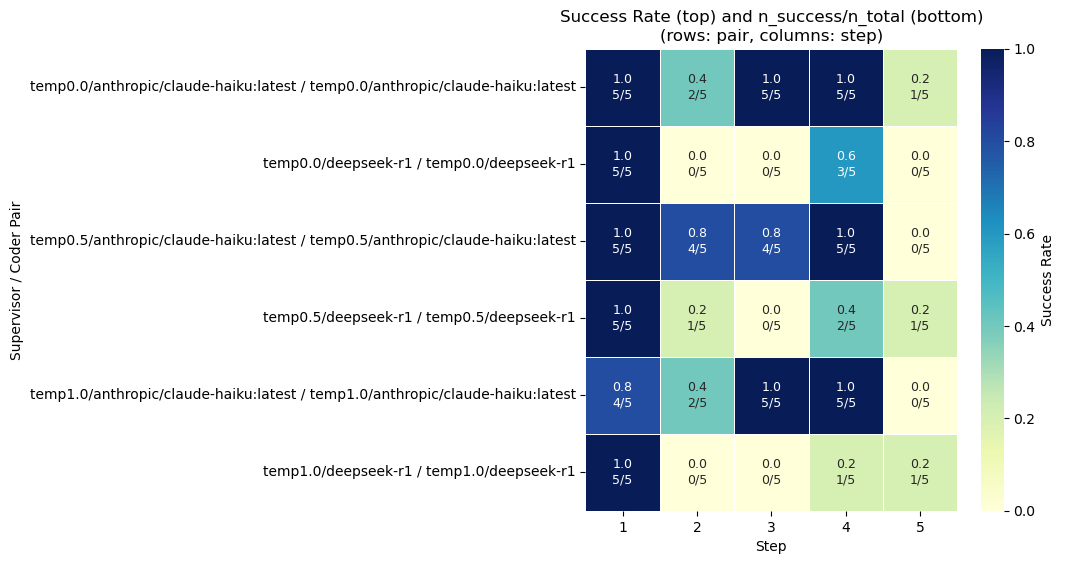

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and prepend for temperature 0
df0 = pd.read_csv('csv/oct_26_temp_0.csv', comment='#')
df0['supervisor'] = 'temp0.0/' + df0['supervisor'].astype(str)
df0['coder']      = 'temp0.0/' + df0['coder'].astype(str)

# Load and prepend for temperature 0.5
df05 = pd.read_csv('csv/oct_26_temp_0.5.csv', comment='#')
df05['supervisor'] = 'temp0.5/' + df05['supervisor'].astype(str)
df05['coder']      = 'temp0.5/' + df05['coder'].astype(str)

# Load and prepend for temperature 1
df1 = pd.read_csv('csv/oct_26_temp_1.0.csv', comment='#')
df1['supervisor'] = 'temp1.0/' + df1['supervisor'].astype(str)
df1['coder']      = 'temp1.0/' + df1['coder'].astype(str)

# Concatenate all DataFrames
df = pd.concat([df0, df05, df1], ignore_index=True)

df['pair'] = df['supervisor'] + ' / ' + df['coder']

summary = (
    df.groupby(['pair', 'step'])
      .agg(success_rate=('success', 'mean'),
           n_success=('success', 'sum'),
           n_total=('success', 'count'))
      .reset_index()
)

summary['step'] = summary['step'].astype(int)
summary = summary.sort_values(['pair', 'step'])

pivot_rate = summary.pivot(index='pair', columns='step', values='success_rate')
pivot_succ = summary.pivot(index='pair', columns='step', values='n_success')
pivot_tot  = summary.pivot(index='pair', columns='step', values='n_total')

annot = pivot_rate.round(2).astype(str) + "\n" + \
        pivot_succ.fillna(0).astype(int).astype(str) + "/" + pivot_tot.fillna(0).astype(int).astype(str)

# ---- Only a single column: sort index alphabetically ----
pivot_rate = pivot_rate.sort_index()
annot = annot.loc[pivot_rate.index]

plt.figure(figsize=(6, max(6, 0.4 * len(pivot_rate))))
sns.heatmap(
    pivot_rate, 
    annot=annot, fmt='', linewidths=.5, cmap="YlGnBu", 
    cbar=True,
    cbar_kws={'label': 'Success Rate'},
    annot_kws={"fontsize":9, "va":"center"},
)

plt.xlabel("Step")
plt.ylabel("Supervisor / Coder Pair")
plt.title("Success Rate (top) and n_success/n_total (bottom)\n(rows: pair, columns: step)")
plt.tick_params(axis='y', labelrotation=0)
plt.tight_layout()
plt.show()

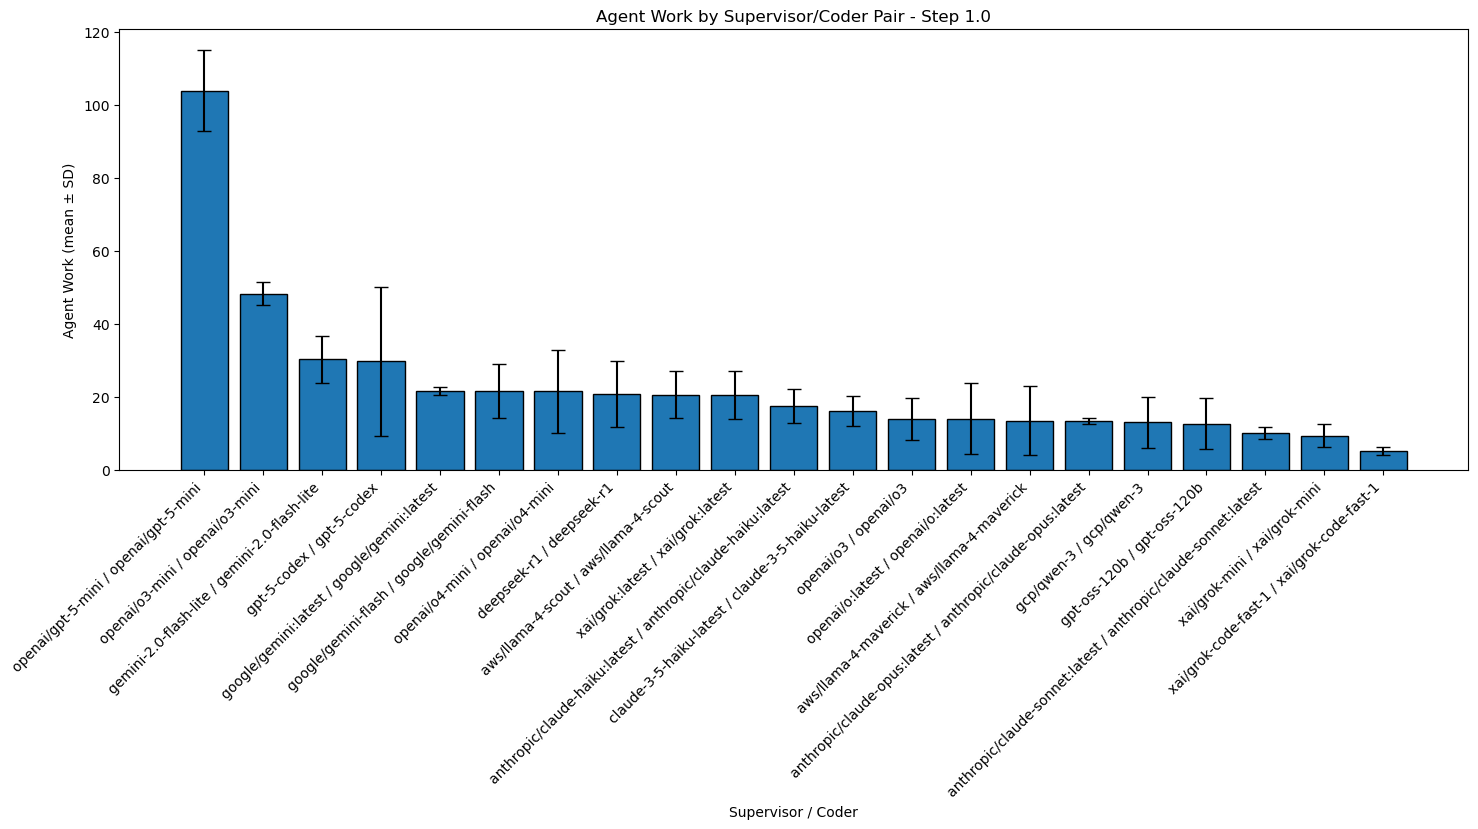

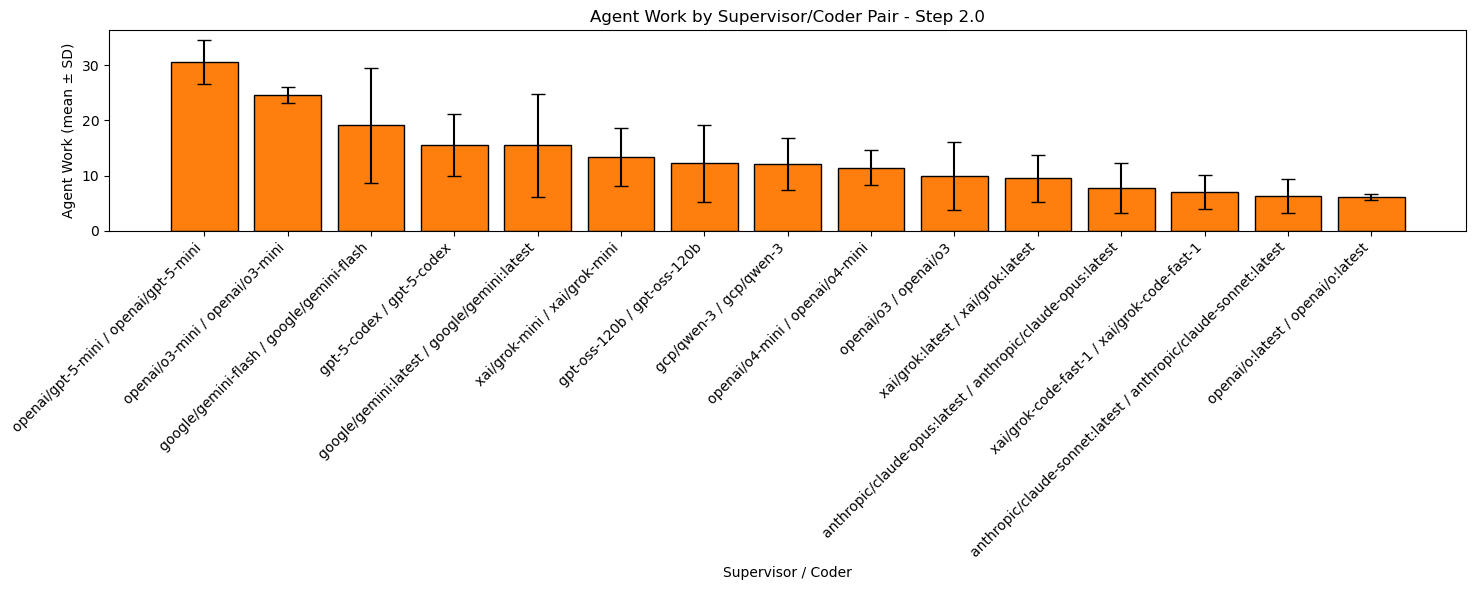

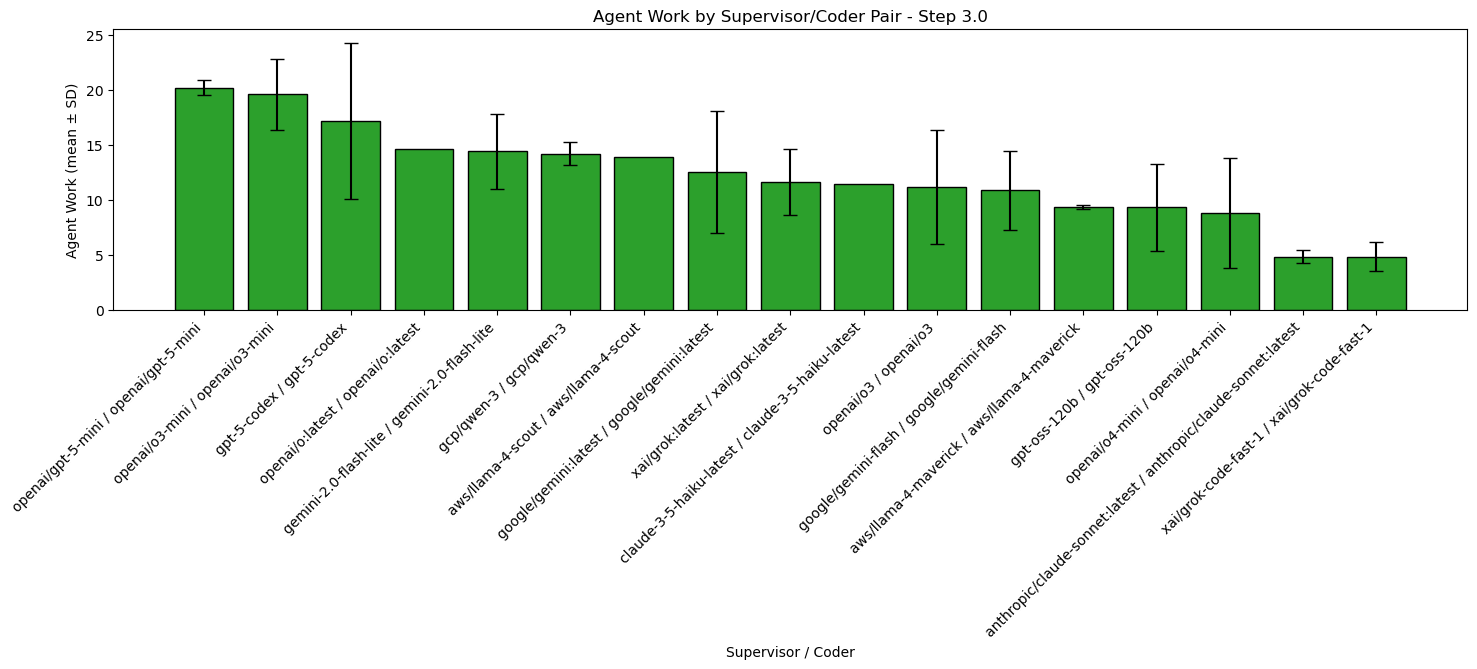

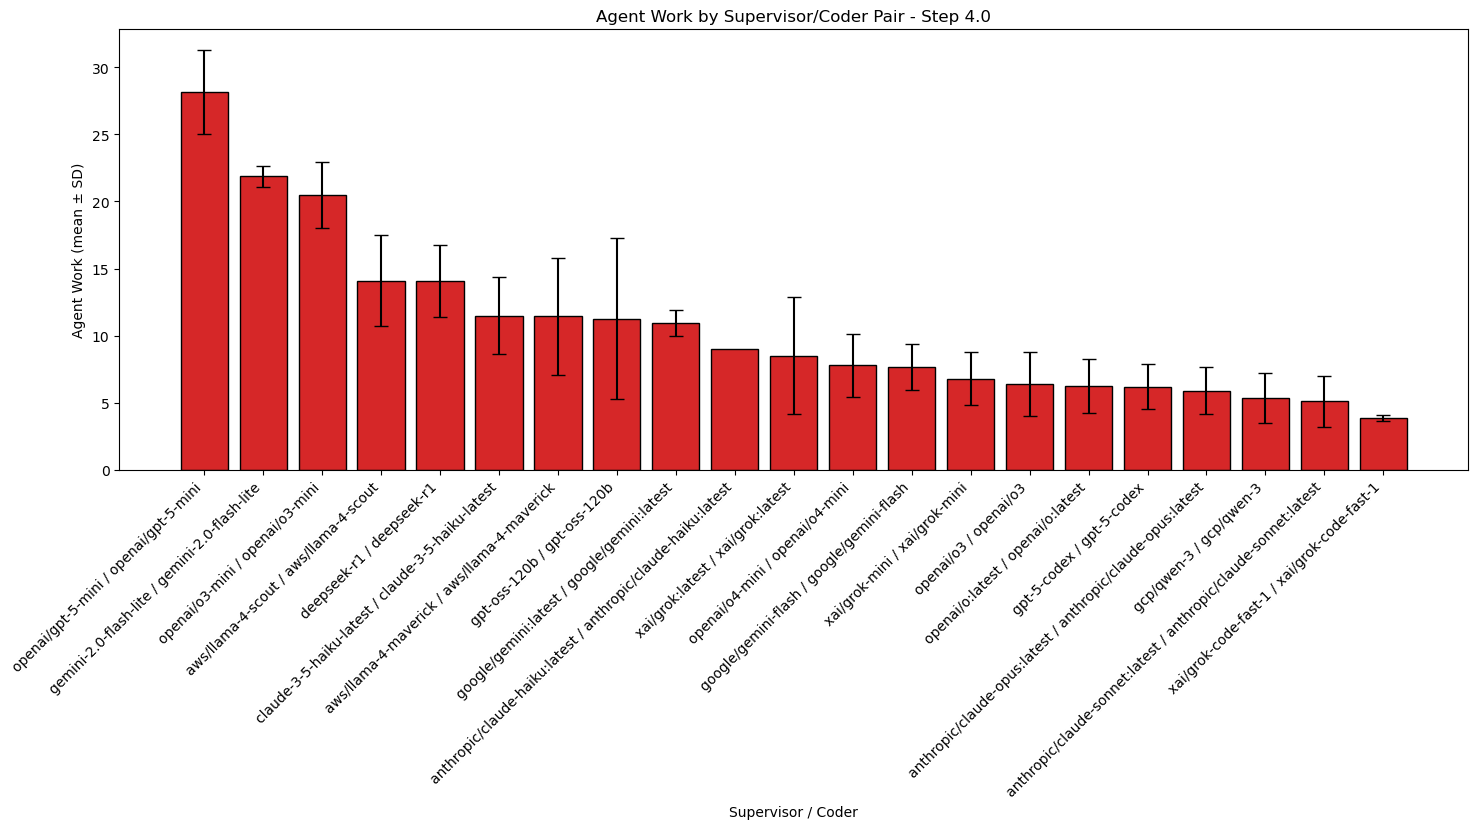

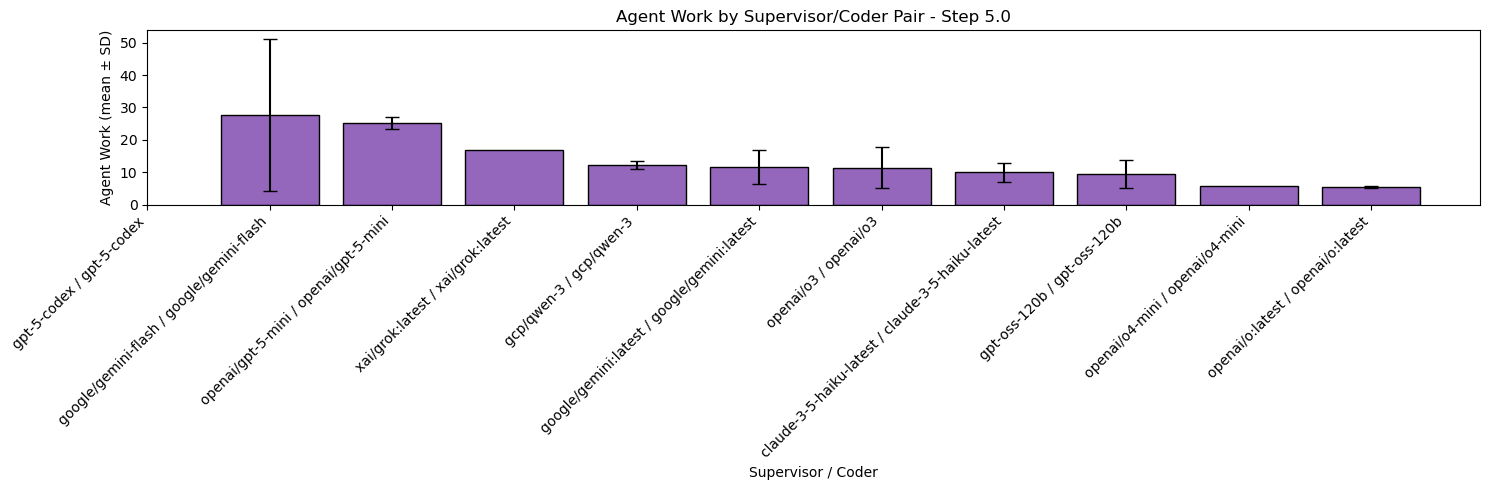

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv('results_summary.csv', comment='#')

# Filter for only successful trials
df = df[df['success'] == True]

# Combine supervisor/coder into a single label for plotting
df['pair'] = df['supervisor'] + ' / ' + df['coder']

# 1. Compute Agent Work for each row
df['agent_work'] = (
    df['input_tokens'] + df['output_tokens'] - df['user_prompt_tokens']
) / df['user_prompt_tokens']

# 2. Group by pair and step, compute mean and std
work_stats = (
    df.groupby(['pair', 'step'])['agent_work']
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .rename(columns={'mean': 'work_mean', 'std': 'work_std', 'count': 'n_trials'})
)

# 3. Loop through each unique step (e.g., 1 through 5)
unique_steps = sorted(work_stats['step'].unique())

# For consistent coloring
step_colors = plt.get_cmap('tab10')

for i, step in enumerate(unique_steps):
    step_df = work_stats[work_stats['step'] == step].copy()
    # Sort by descending mean for pretty plot
    step_df = step_df.sort_values('work_mean', ascending=False).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(15, max(5, 0.4 * len(step_df))))
    y = np.arange(len(step_df))
    ax.bar(
        y,
        step_df['work_mean'],
        yerr=step_df['work_std'],
        capsize=5,
        color=step_colors(i),   # one color per step
        edgecolor='black'
    )
    ax.set_xticks(y)
    ax.set_xticklabels(step_df['pair'], rotation=45, ha='right')
    ax.set_ylabel('Agent Work (mean ± SD)')
    ax.set_title(f'Agent Work by Supervisor/Coder Pair - Step {step}')
    ax.set_xlabel('Supervisor / Coder')
    
    plt.tight_layout()
    plt.show()

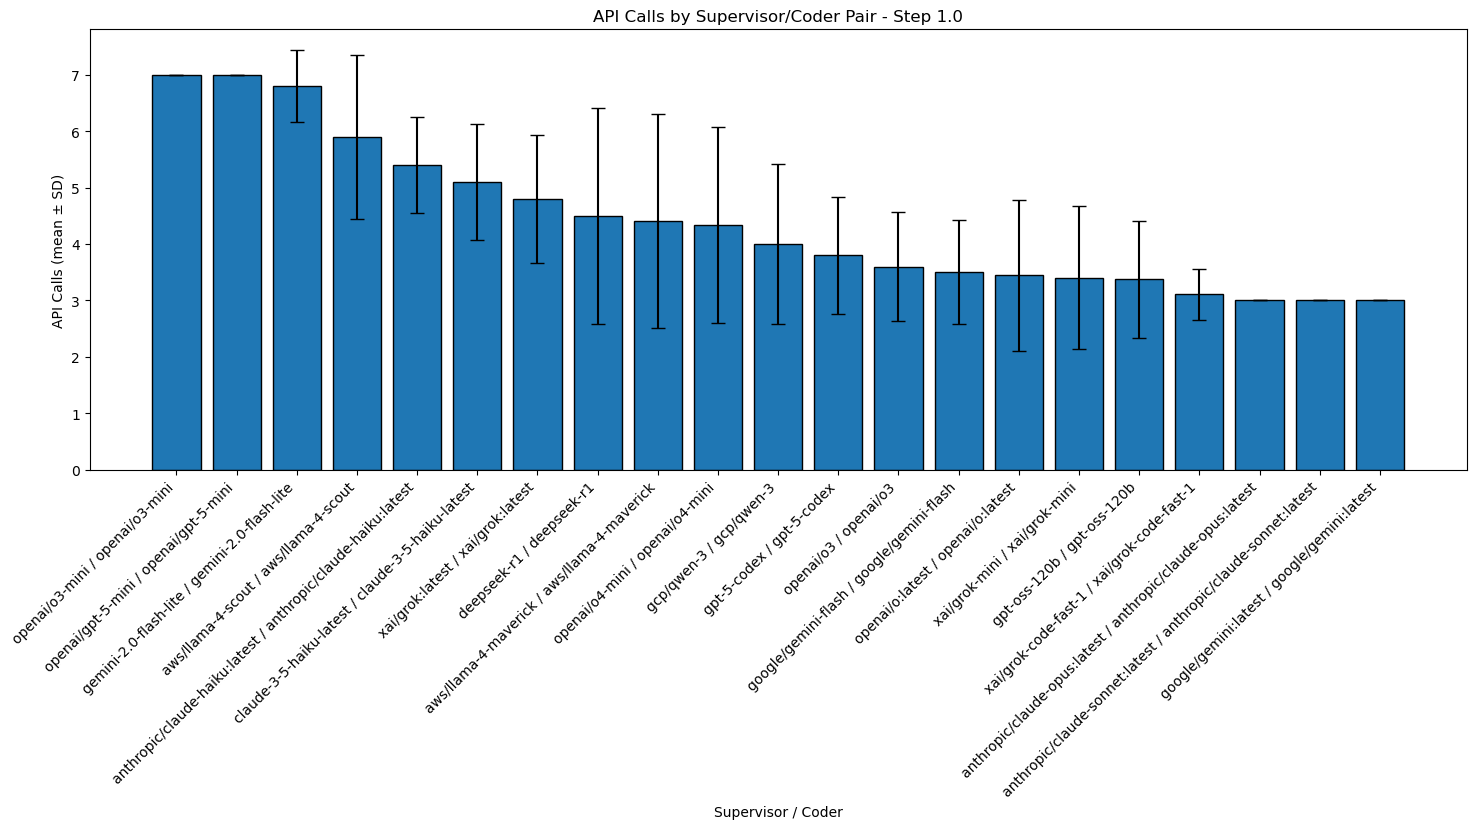

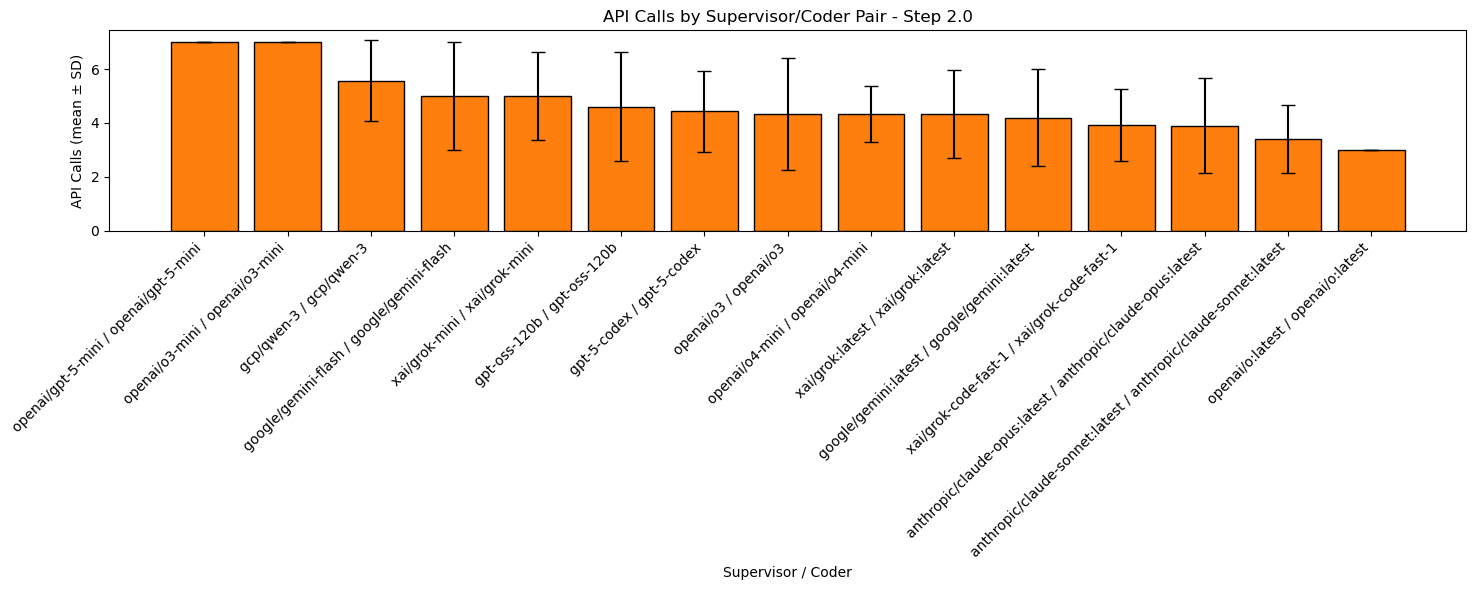

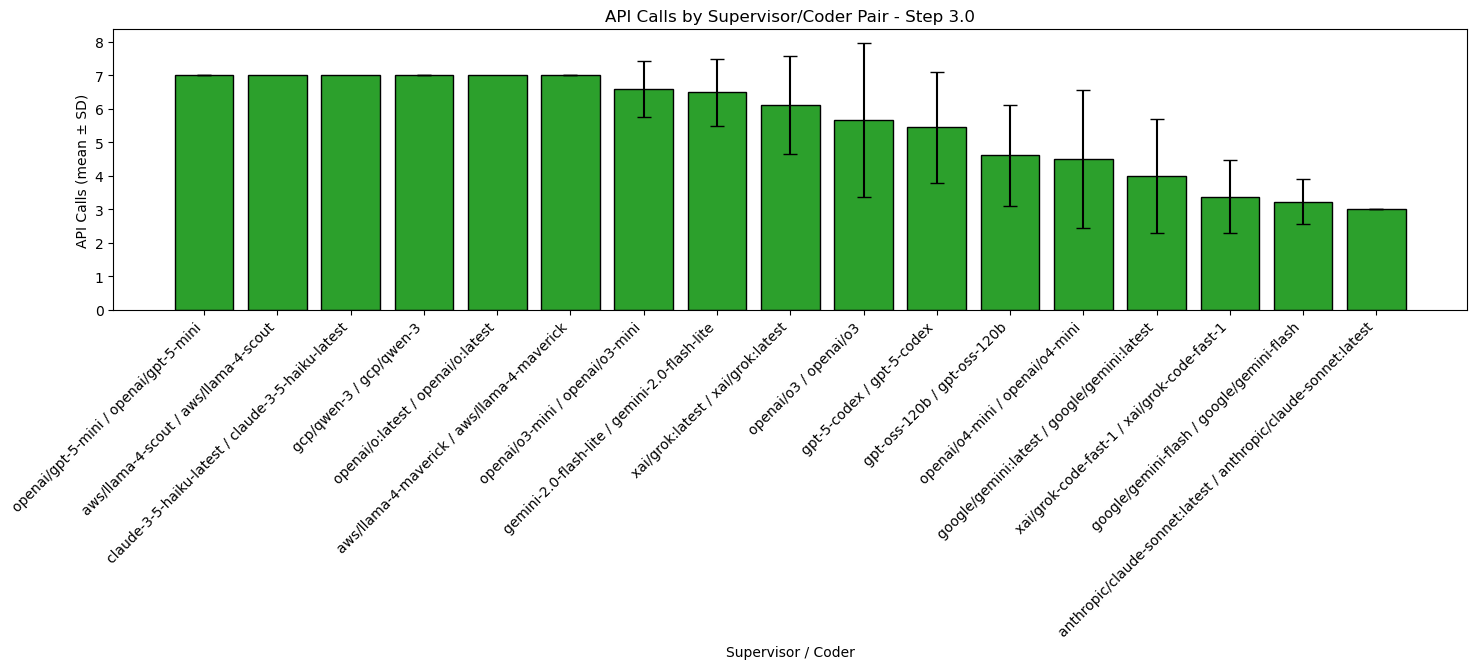

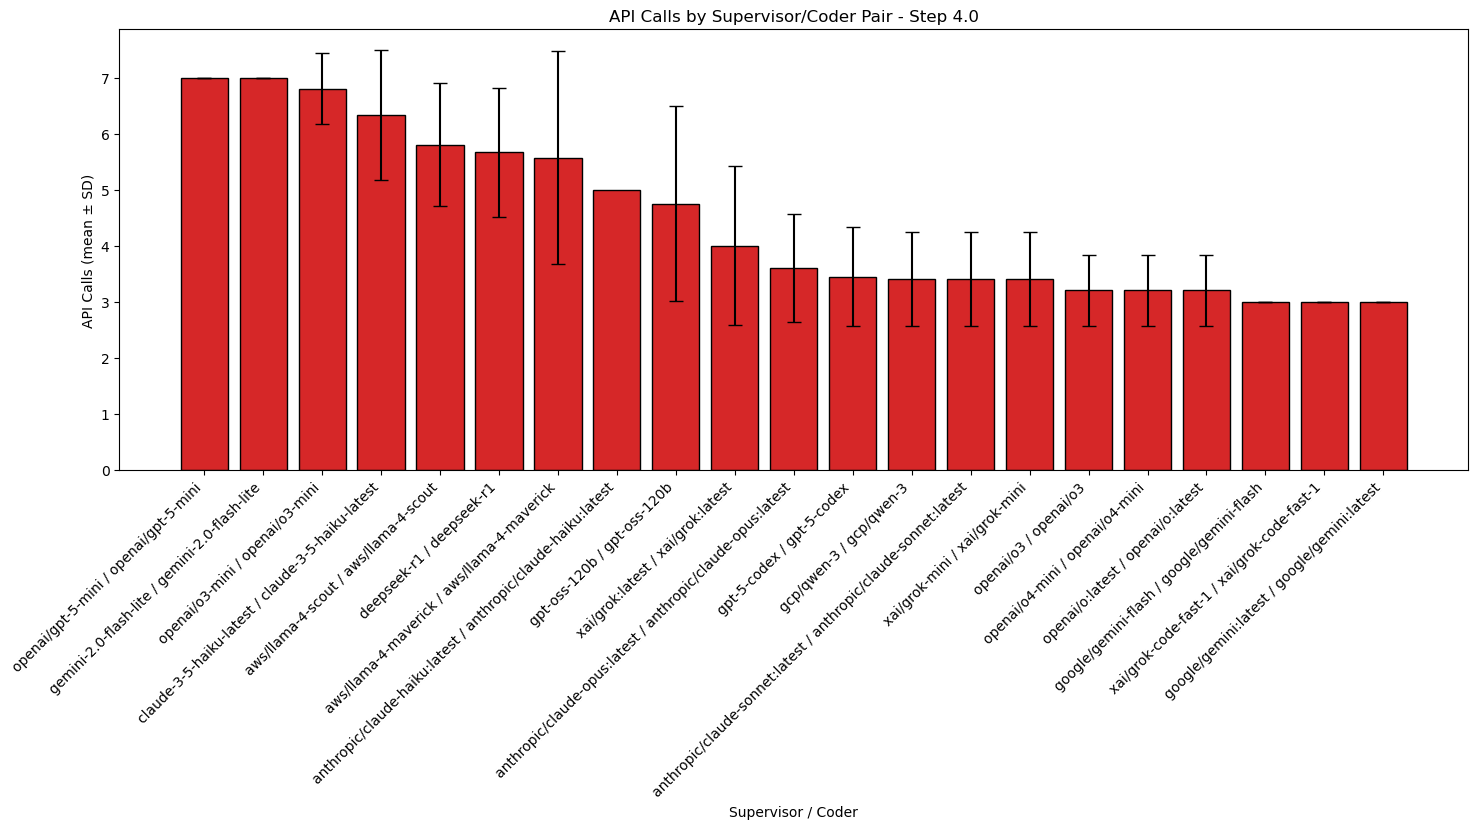

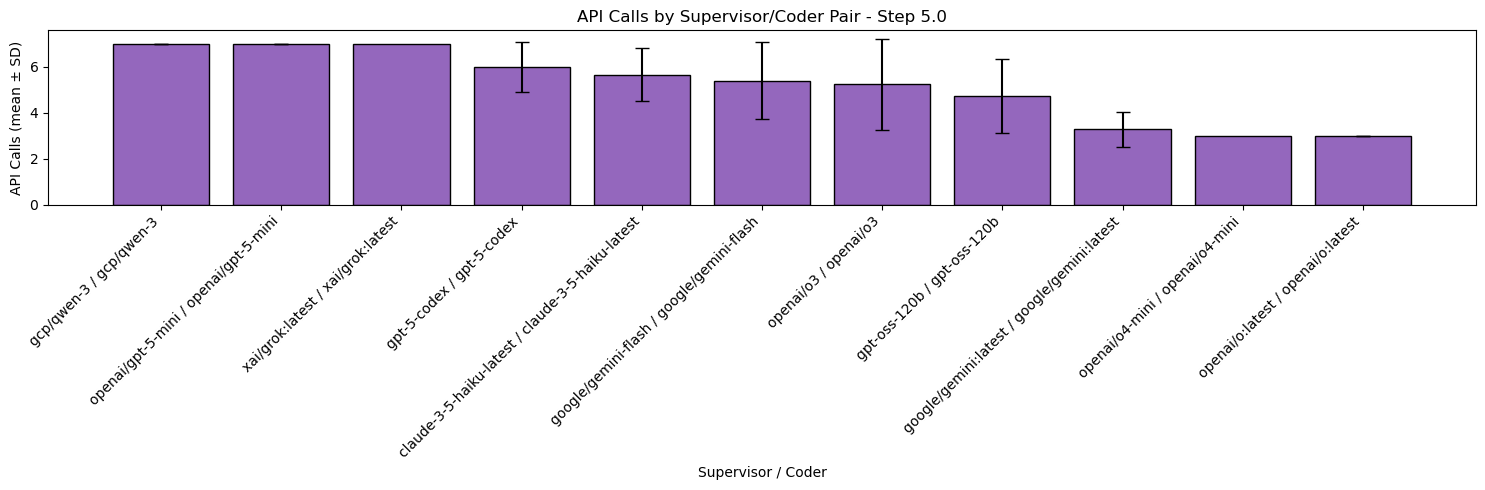

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv('results_summary.csv', comment='#')

# Filter for only successful trials
df = df[df['success'] == True]

# Combine supervisor/coder into a single label for plotting
df['pair'] = df['supervisor'] + ' / ' + df['coder']

# GROUP BY pair and step, compute mean and std of API_calls
api_stats = (
    df.groupby(['pair', 'step'])['API_calls']
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .rename(columns={'mean': 'api_mean', 'std': 'api_std', 'count': 'n_trials'})
)

# Loop through each unique step (e.g., 1 through 5)
unique_steps = sorted(api_stats['step'].unique())

step_colors = plt.get_cmap('tab10')

for i, step in enumerate(unique_steps):
    step_df = api_stats[api_stats['step'] == step].copy()
    # Sort by descending mean for pretty plot
    step_df = step_df.sort_values('api_mean', ascending=False).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(15, max(5, 0.4 * len(step_df))))
    y = np.arange(len(step_df))
    ax.bar(
        y,
        step_df['api_mean'],
        yerr=step_df['api_std'],
        capsize=5,
        color=step_colors(i),
        edgecolor='black'
    )
    ax.set_xticks(y)
    ax.set_xticklabels(step_df['pair'], rotation=45, ha='right')
    ax.set_ylabel('API Calls (mean ± SD)')
    ax.set_title(f'API Calls by Supervisor/Coder Pair - Step {step}')
    ax.set_xlabel('Supervisor / Coder')
    
    plt.tight_layout()
    plt.show()

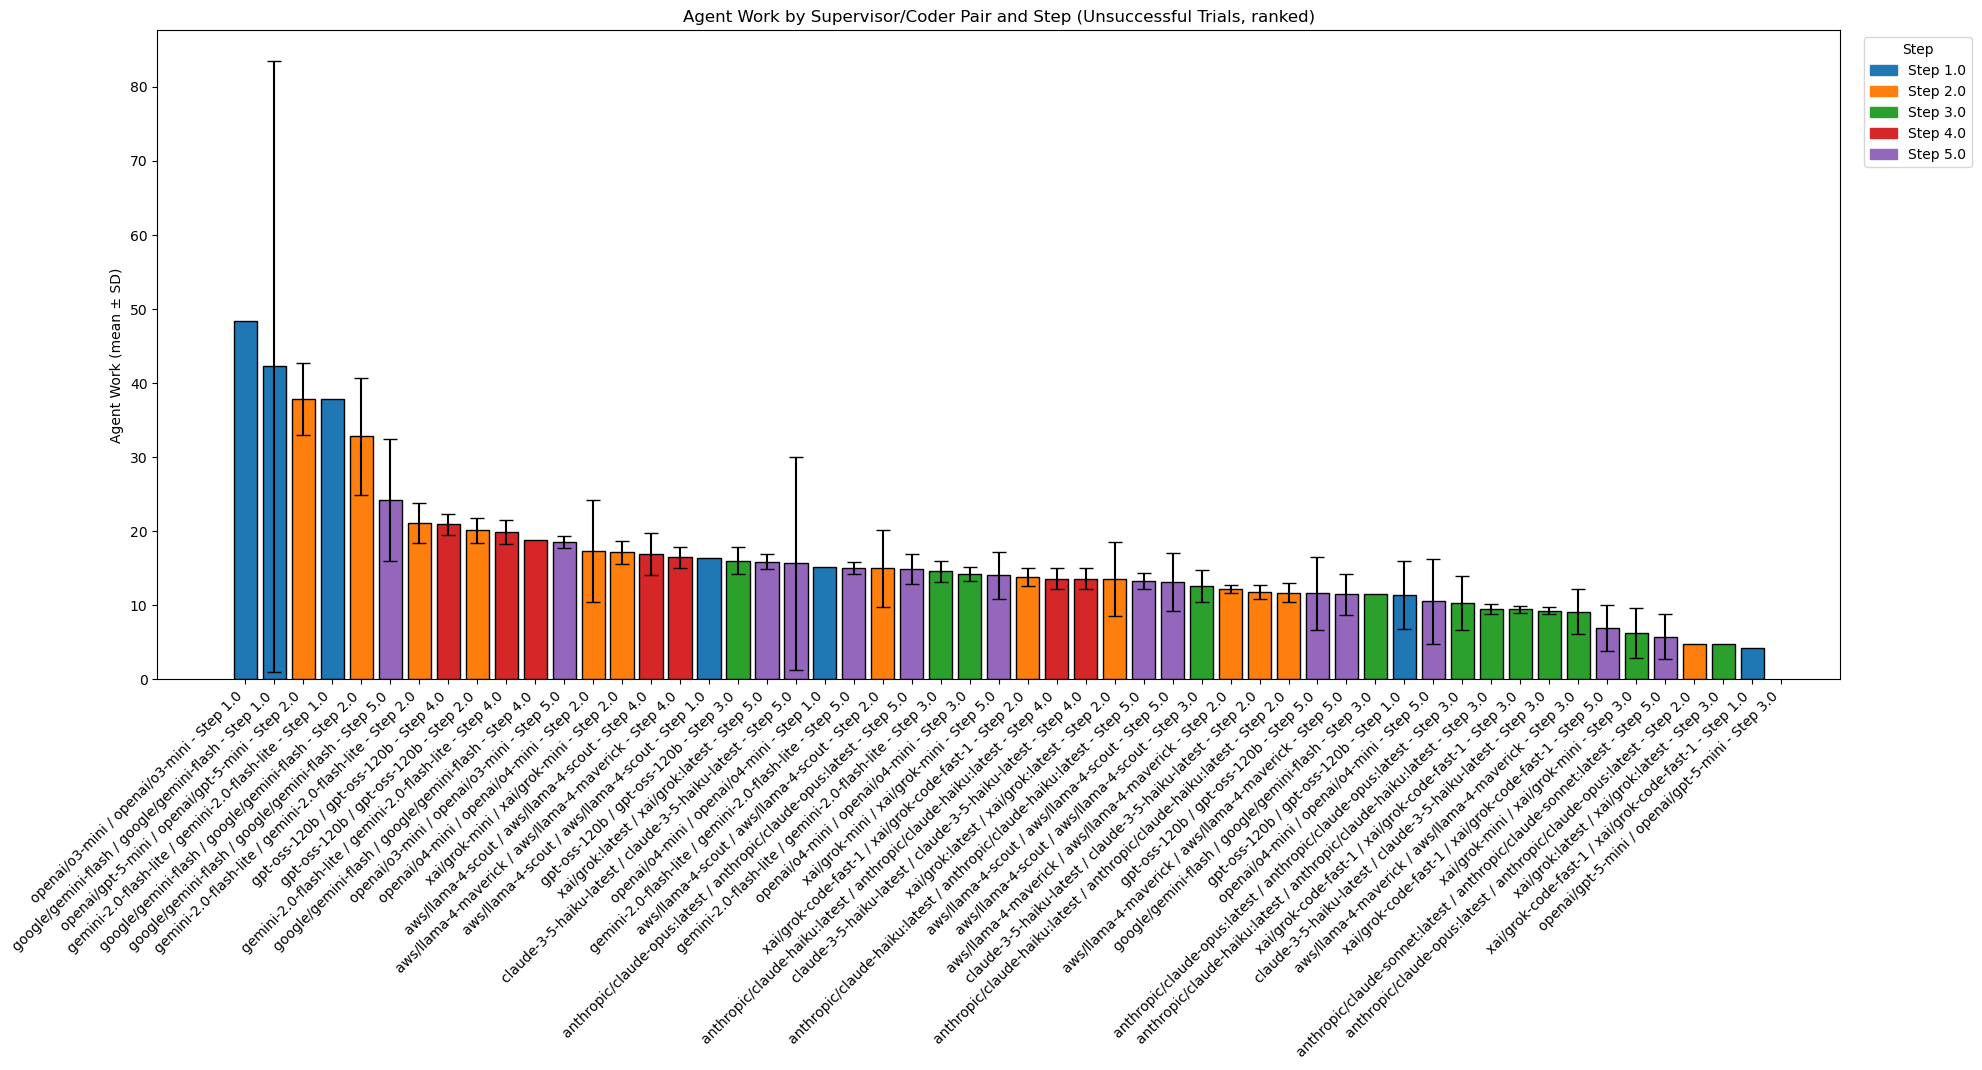

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Load data
df = pd.read_csv('results_summary.csv', comment='#')

# Filter for only unsuccessful trials
df = df[df['success'] == False]

# Combine supervisor/coder into a single label for plotting
df['pair'] = df['supervisor'] + ' / ' + df['coder']

# 1. Compute Agent Work for each row
df['agent_work'] = (
    df['input_tokens'] + df['output_tokens'] - df['user_prompt_tokens']
) / df['user_prompt_tokens']

# 2. Group by pair and step, compute mean and std
work_stats = (
    df.groupby(['pair', 'step'])['agent_work']
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .rename(columns={'mean': 'work_mean', 'std': 'work_std', 'count': 'n_trials'})
)

# 3. Build labels for plotting (pair - step)
work_stats['label'] = work_stats['pair'] + ' - Step ' + work_stats['step'].astype(str)

# 4. Sort by mean agent work descending
work_stats = work_stats.sort_values('work_mean', ascending=False).reset_index(drop=True)

# 5. Assign a color to each step
unique_steps = sorted(work_stats['step'].unique())
step_colors = dict(zip(unique_steps, cm.tab10.colors[:len(unique_steps)]))
bar_colors = work_stats['step'].map(step_colors)

# 6. Plot
fig, ax = plt.subplots(figsize=(20, max(6, 0.2*len(work_stats))))
y = np.arange(len(work_stats))
ax.bar(
    y,
    work_stats['work_mean'],
    yerr=work_stats['work_std'],
    capsize=5,
    color=bar_colors,
    edgecolor='black'
)

ax.set_xticks(y)
ax.set_xticklabels(work_stats['label'], rotation=45, ha='right')
ax.set_ylabel('Agent Work (mean ± SD)')
ax.set_title('Agent Work by Supervisor/Coder Pair and Step (Unsuccessful Trials, ranked)')
# Legend for steps
handles = [plt.Rectangle((0,0),1,1, color=step_colors[s]) for s in unique_steps]
labels = [f'Step {s}' for s in unique_steps]
ax.legend(handles, labels, title='Step', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()

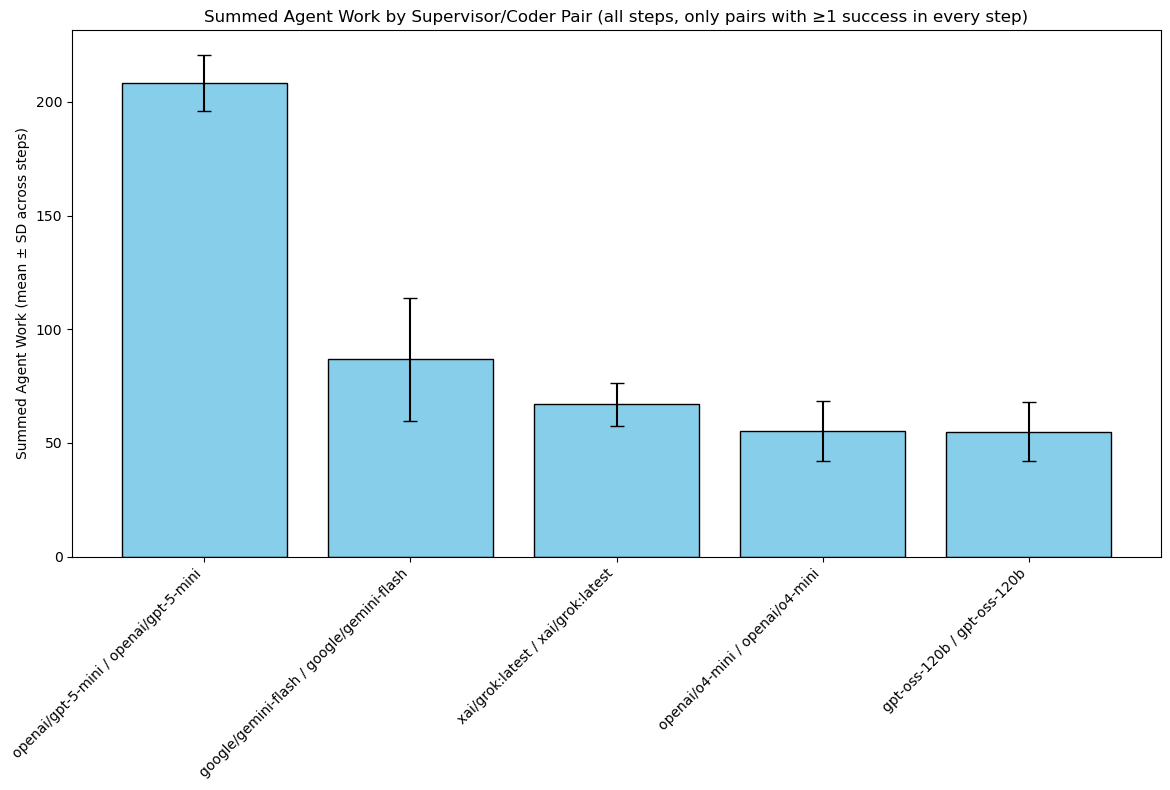

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm

# Load data
df = pd.read_csv('results_summary.csv', comment='#')

# Filter for only successful trials
df = df[df['success'] == True]

# Combine supervisor/coder into a single label for plotting
df['pair'] = df['supervisor'] + ' / ' + df['coder']

# Required steps (adjust if they're not 1-5)
required_steps = set([1, 2, 3, 4, 5])

# Find pairs with at least one success for each of the required steps
pairs_with_all_steps = (
    df.groupby('pair')['step']
      .apply(lambda steps: required_steps.issubset(set(steps)))
)

# Only keep those pairs
valid_pairs = pairs_with_all_steps[pairs_with_all_steps].index
df = df[df['pair'].isin(valid_pairs)]

# 1. Compute Agent Work for each row
df['agent_work'] = (
    df['input_tokens'] + df['output_tokens'] - df['user_prompt_tokens']
) / df['user_prompt_tokens']

# 2. Group by pair and step, compute mean and std
work_stats = (
    df.groupby(['pair', 'step'])['agent_work']
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .rename(columns={'mean': 'work_mean', 'std': 'work_std', 'count': 'n_trials'})
)

# 3. Sum means and propagate errors for each pair (across all steps)
def sum_pair_stats(group):
    total_mean = group['work_mean'].sum()
    total_var = (group['work_std'] ** 2).sum()
    total_std = np.sqrt(total_var)
    total_trials = group['n_trials'].sum()
    return pd.Series({'sum_work_mean': total_mean, 'sum_work_std': total_std, 'total_trials': total_trials})

pair_sums = work_stats.groupby('pair').apply(sum_pair_stats).reset_index()

# 4. Sort by summed mean descending
pair_sums = pair_sums.sort_values('sum_work_mean', ascending=False).reset_index(drop=True)

# 5. Plot
fig, ax = plt.subplots(figsize=(12, 8))
y = np.arange(len(pair_sums))
ax.bar(
    y,
    pair_sums['sum_work_mean'],
    yerr=pair_sums['sum_work_std'],
    capsize=5,
    color='skyblue',
    edgecolor='black'
)

ax.set_xticks(y)
ax.set_xticklabels(pair_sums['pair'], rotation=45, ha='right')
ax.set_ylabel('Summed Agent Work (mean ± SD across steps)')
ax.set_title('Summed Agent Work by Supervisor/Coder Pair (all steps, only pairs with ≥1 success in every step)')
plt.tight_layout()
plt.show()

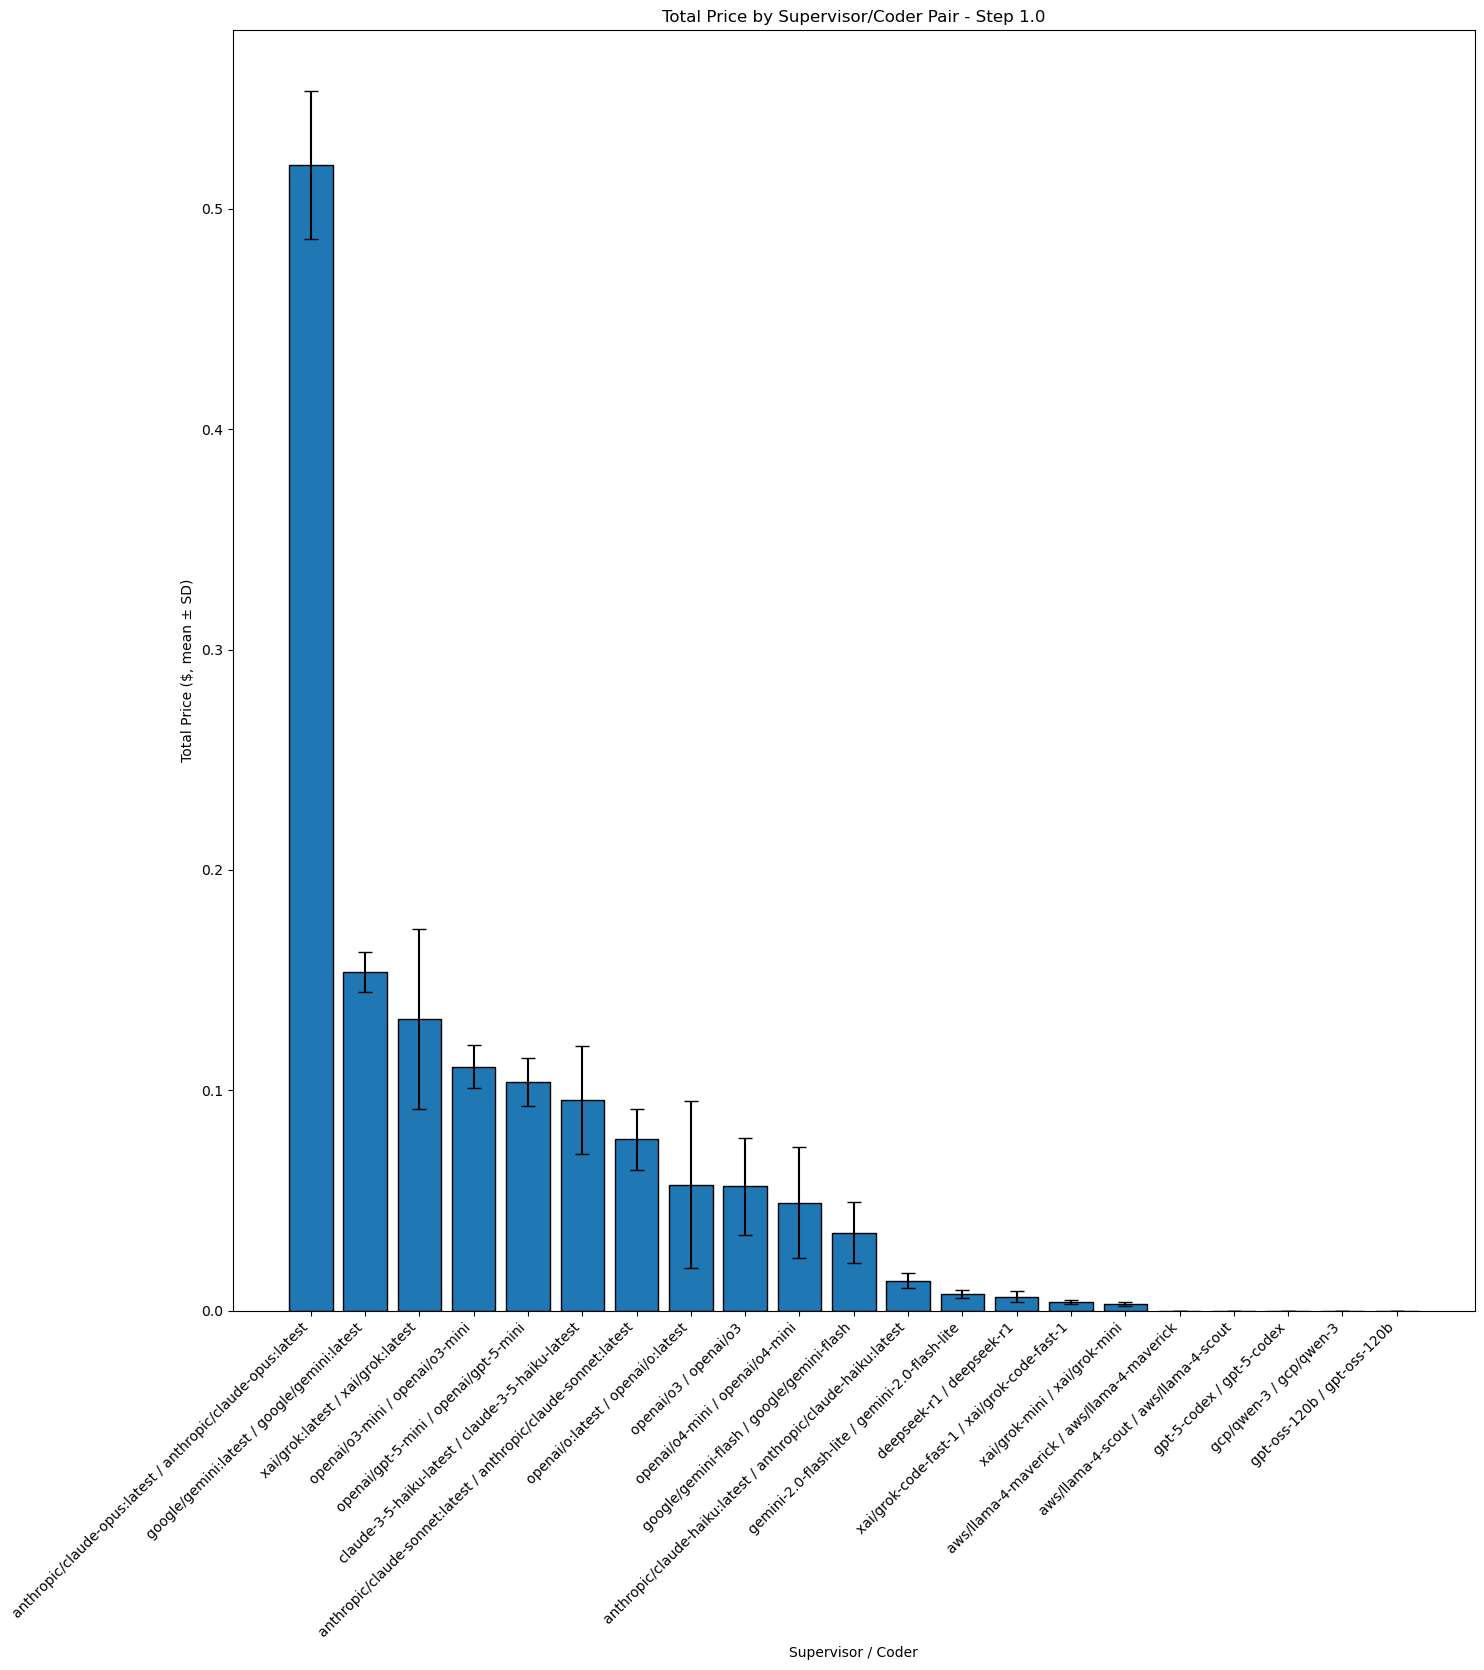

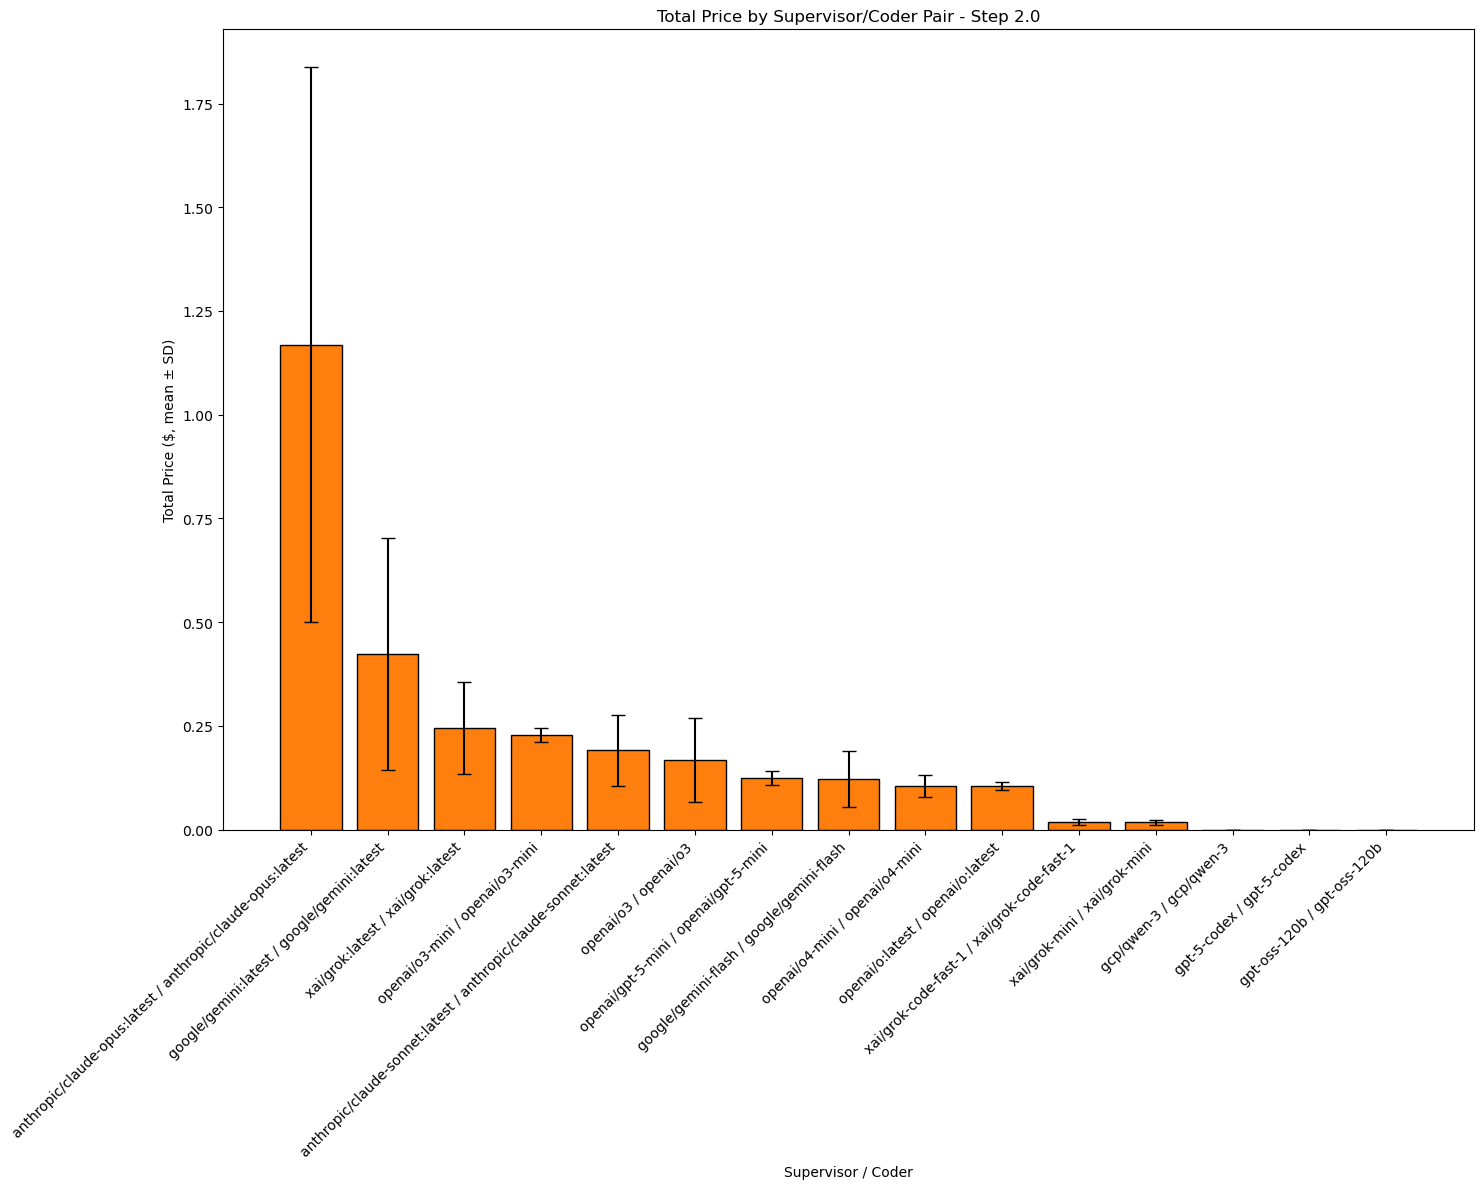

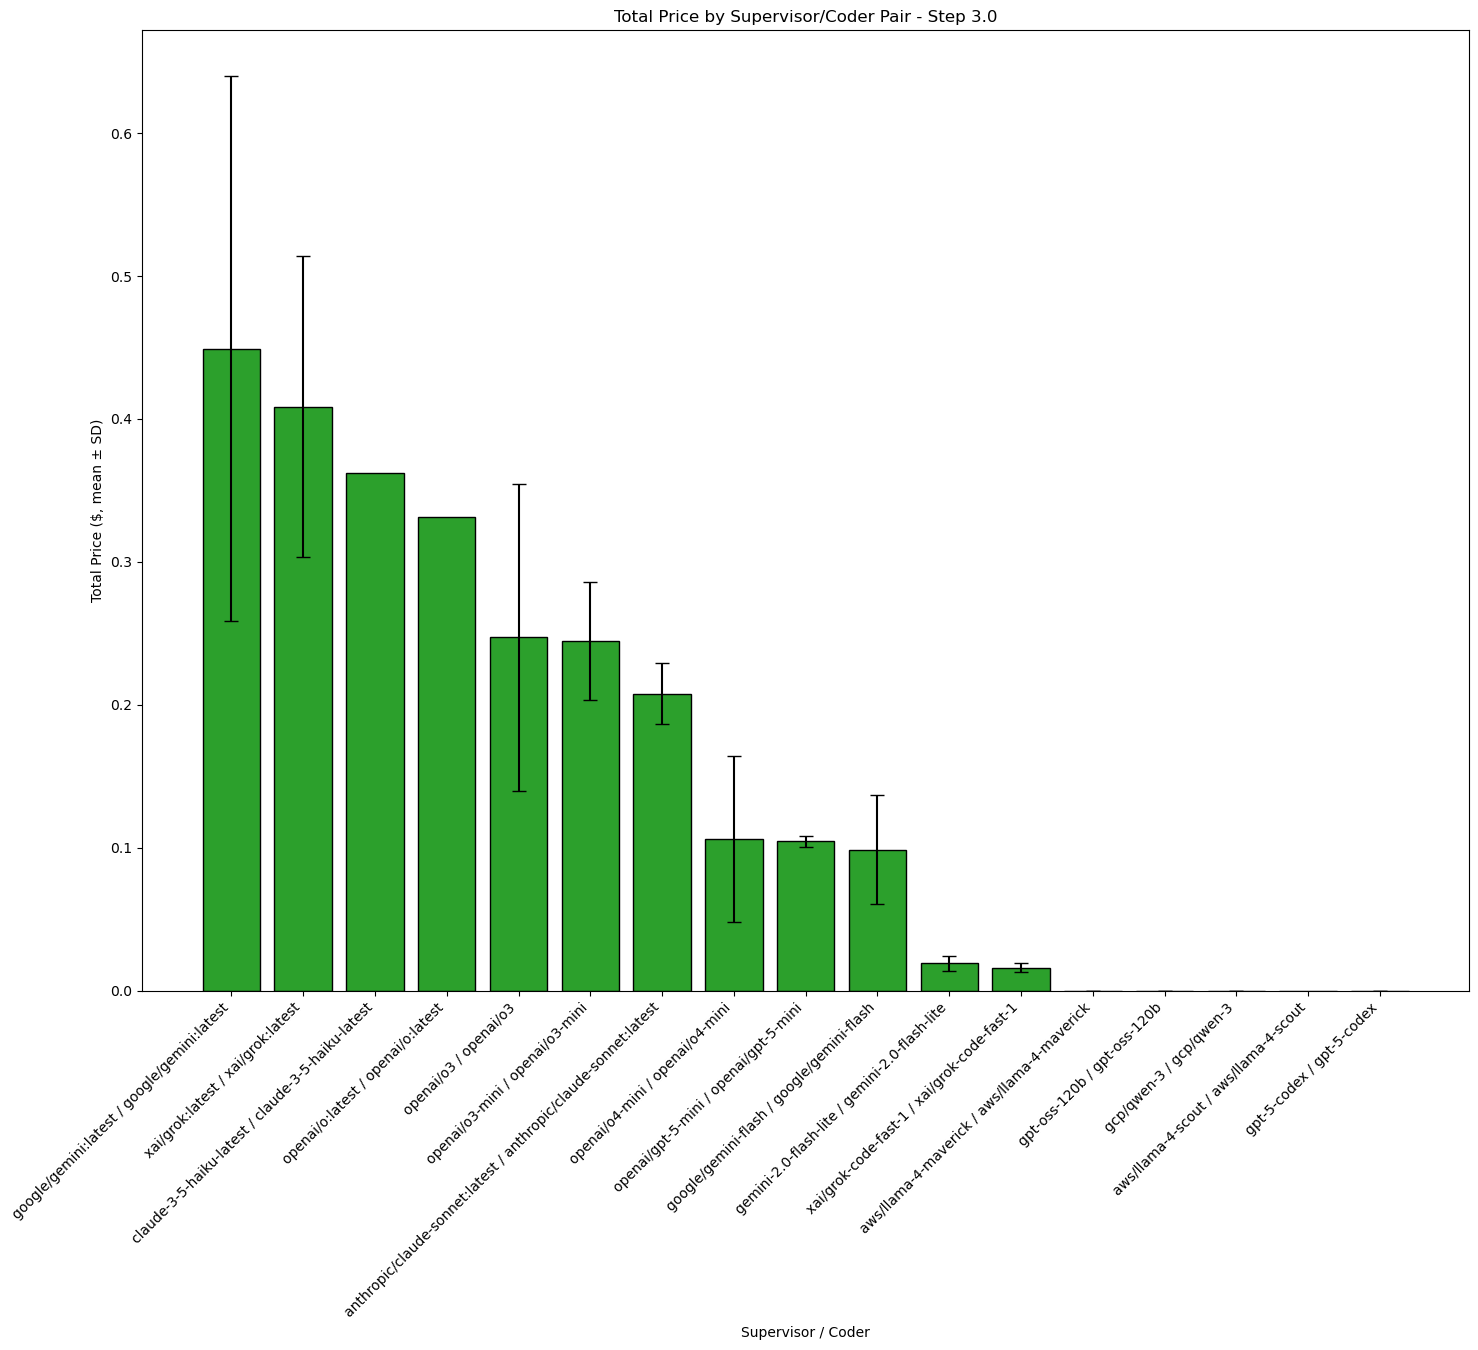

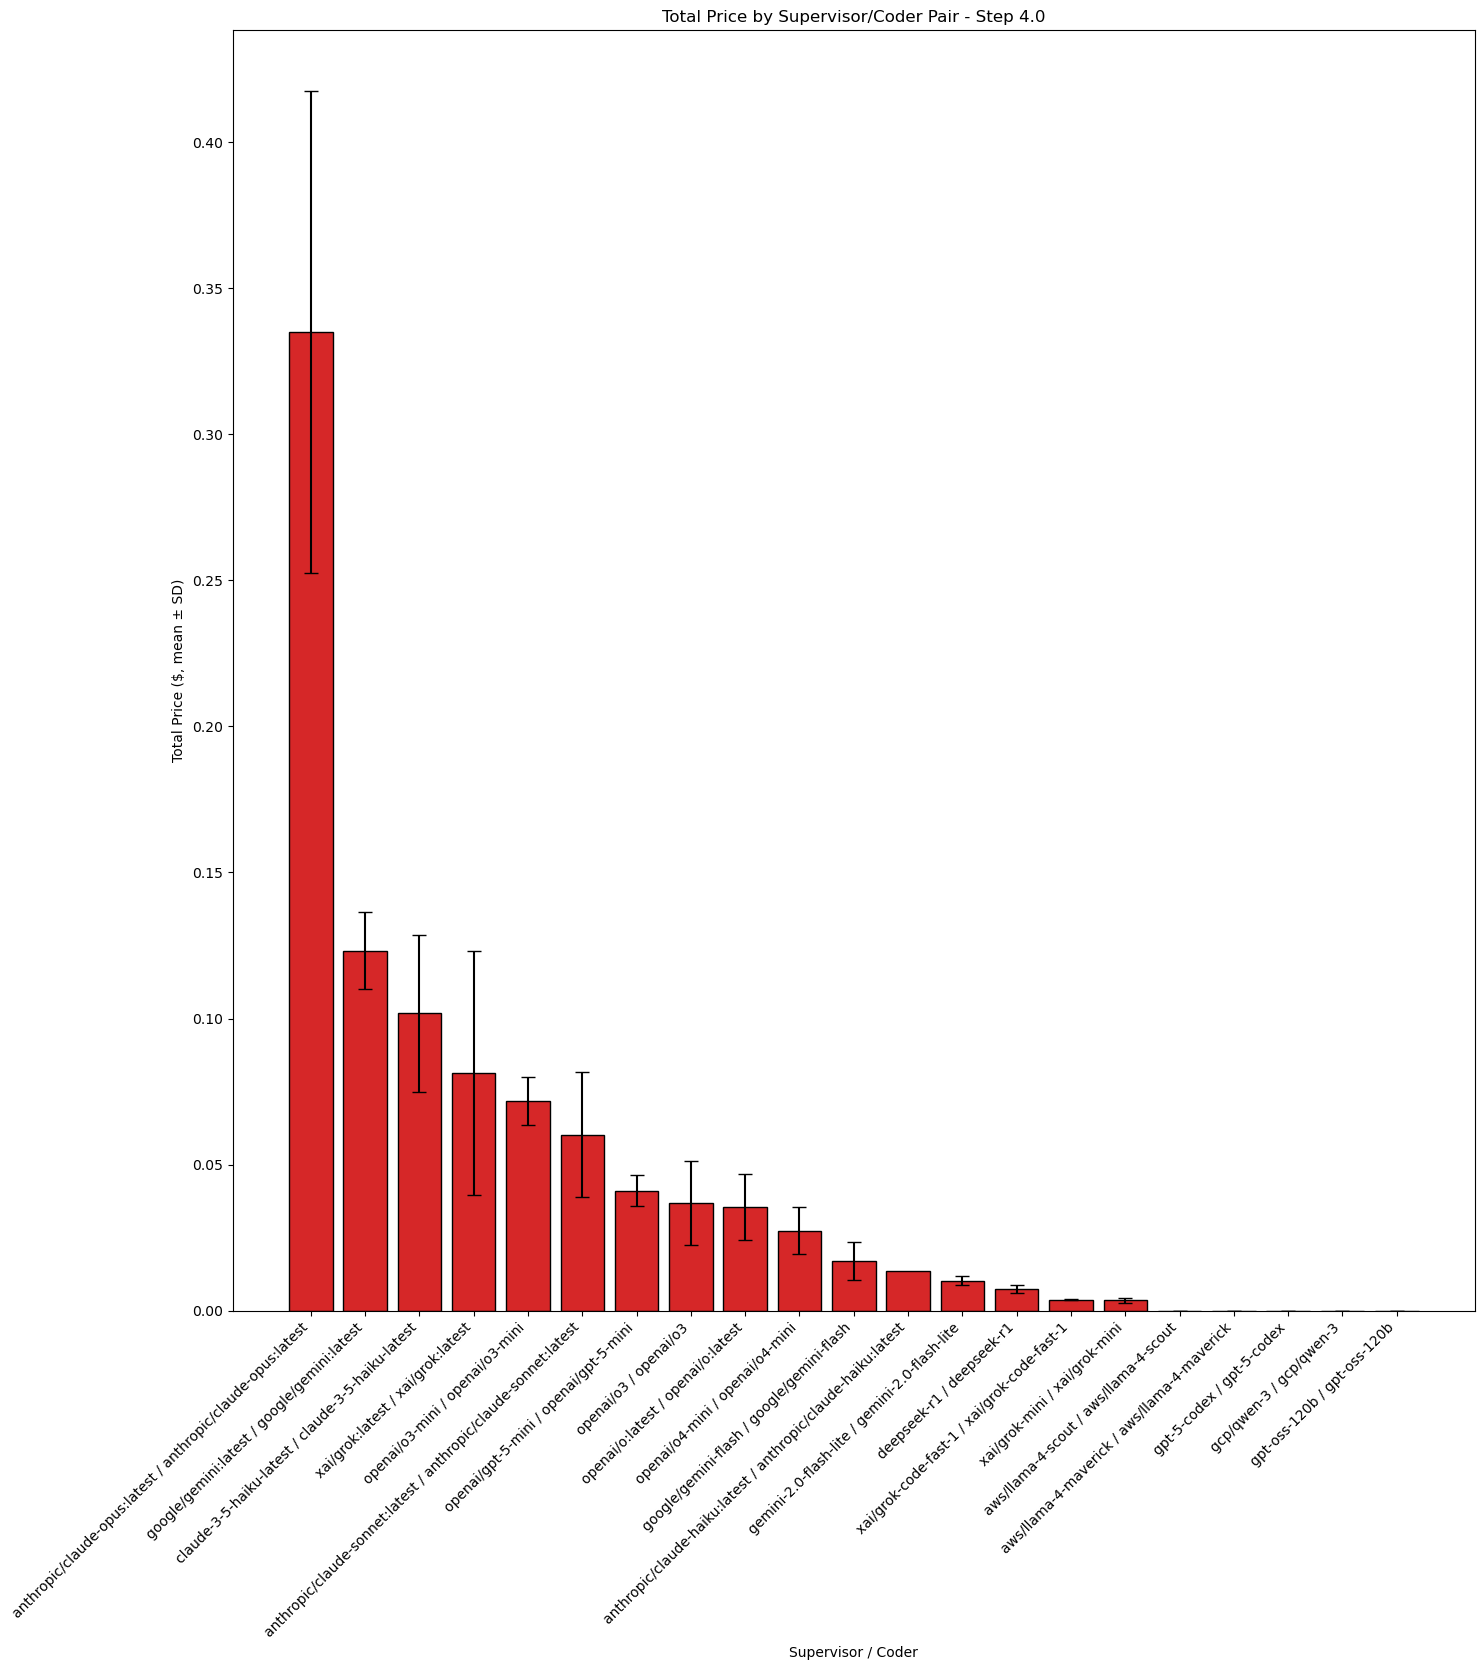

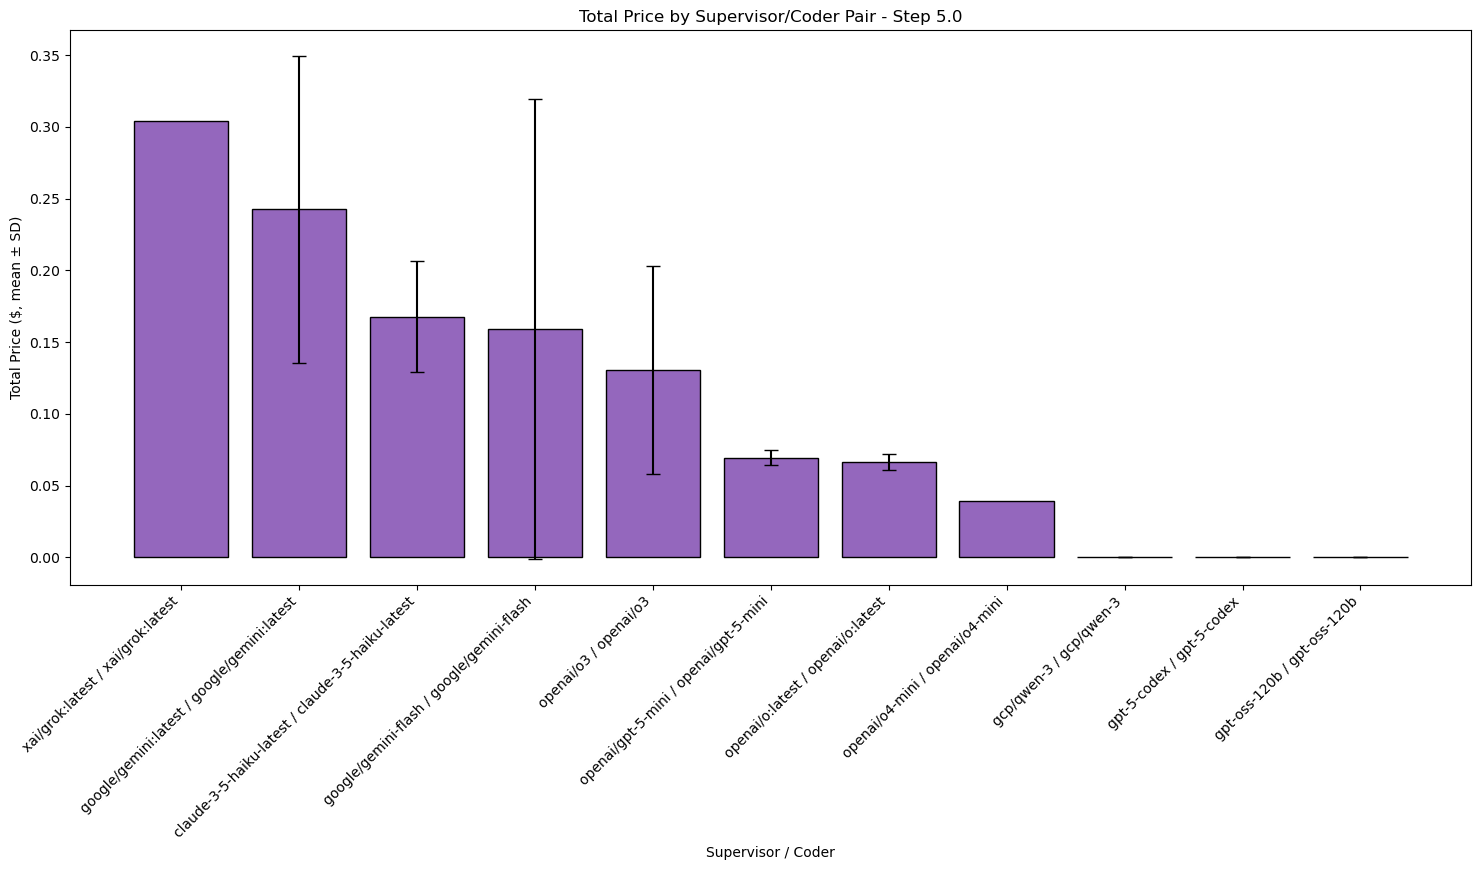

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Cost tables ---
input_cost = {
    "openai/gpt-5":1.25,
    "openai/gpt-5-mini":0.25,
    "openai/o4-mini":1.10,
    "google/gemini-pro":1.25,
    "google/gemini:latest":1.25,
    "google/gemini-2.0-flash-lite":0.10,
    "gemini-2.0-flash-lite":0.10,
    "google/gemini-flash":0.30,
    "anthropic/claude-haiku":0.80,
    "anthropic/claude-haiku:latest":0.80,
    "claude-3-5-haiku-latest":0.80,
    "anthropic/claude-opus":15,
    "anthropic/claude-opus:latest":15,
    "anthropic/claude-sonnet":3.0,
    "anthropic/claude-sonnet:latest":3.0,
    "xai/grok-code-fast-1":0.20,
    "xai/grok:latest":3,
    "openai/o3-mini":1.10,
    "google/gemini-flash":0.3,
    "xai/grok-mini":0.30,
    "openai/o3":2,
    "openai/o:latest":2,
    "deepseek-r1":0.28,
}

output_cost = {
    "openai/gpt-5":10.0,
    "openai/gpt-5-mini":2.0,
    "openai/o4-mini":4.0,
    "google/gemini-pro":10.0,
    "google/gemini:latest":10.0,
    "google/gemini-2.0-flash-lite":0.40,
    "gemini-2.0-flash-lite":0.40,
    "google/gemini-flash":2.50,
    "anthropic/claude-haiku":0.80,
    "anthropic/claude-haiku:latest":0.80,
    "claude-3-5-haiku-latest":15,
    "anthropic/claude-opus":75,
    "anthropic/claude-opus:latest":75,
    "anthropic/claude-sonnet":15.0,
    "anthropic/claude-sonnet:latest":15.0,
    "xai/grok-code-fast-1":1.50,
    "xai/grok:latest":15,
    "openai/o3-mini":4.40,
    "google/gemini-flash":2.50,
    "xai/grok-mini":0.50,
    "openai/o3":8,
    "openai/o:latest":8,
    "deepseek-r1":0.42,
    
    
}

# --- Load and filter data ---
df = pd.read_csv('results_summary.csv', comment='#')
df = df[df['success'] == True]

# Combine supervisor/coder into a single label for plotting
df['pair'] = df['supervisor'] + ' / ' + df['coder']

# --- Compute total price ---
def compute_total_price(row):
    sup_model = row['supervisor']
    cod_model = row['coder']
    # Supervisor cost
    sup_icost = input_cost.get(sup_model, 0)
    sup_ocost = output_cost.get(sup_model, 0)
    # Coder cost
    cod_icost = input_cost.get(cod_model, 0)
    cod_ocost = output_cost.get(cod_model, 0)
    # Total cost: each gets the full input/output tokens
    sup_cost = (row['input_tokens']/1e6)*sup_icost + (row['output_tokens']/1e6)*sup_ocost
    cod_cost = (row['input_tokens']/1e6)*cod_icost + (row['output_tokens']/1e6)*cod_ocost
    return sup_cost + cod_cost

df['total_price'] = df.apply(compute_total_price, axis=1)

# --- Group by pair and step, compute mean and std ---
cost_stats = (
    df.groupby(['pair', 'step'])['total_price']
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .rename(columns={'mean': 'cost_mean', 'std': 'cost_std', 'count': 'n_trials'})
)

# Only keep pairs/steps with nonzero average cost
cost_stats = cost_stats[cost_stats['cost_mean'] > -1]

# --- One plot per step ---
unique_steps = sorted(cost_stats['step'].unique())
step_colors = plt.get_cmap('tab10')

for i, step in enumerate(unique_steps):
    step_df = cost_stats[cost_stats['step'] == step].copy()
    step_df = step_df.sort_values('cost_mean', ascending=False).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(15, max(5, 0.8 * len(step_df))))
    y = np.arange(len(step_df))
    ax.bar(
        y,
        step_df['cost_mean'],
        yerr=step_df['cost_std'],
        capsize=5,
        color=step_colors(i),
        edgecolor='black'
    )
    ax.set_xticks(y)
    ax.set_xticklabels(step_df['pair'], rotation=45, ha='right')
    ax.set_ylabel('Total Price ($, mean ± SD)')
    ax.set_title(f'Total Price by Supervisor/Coder Pair - Step {step}')
    ax.set_xlabel('Supervisor / Coder')
    
    plt.tight_layout()
    plt.show()

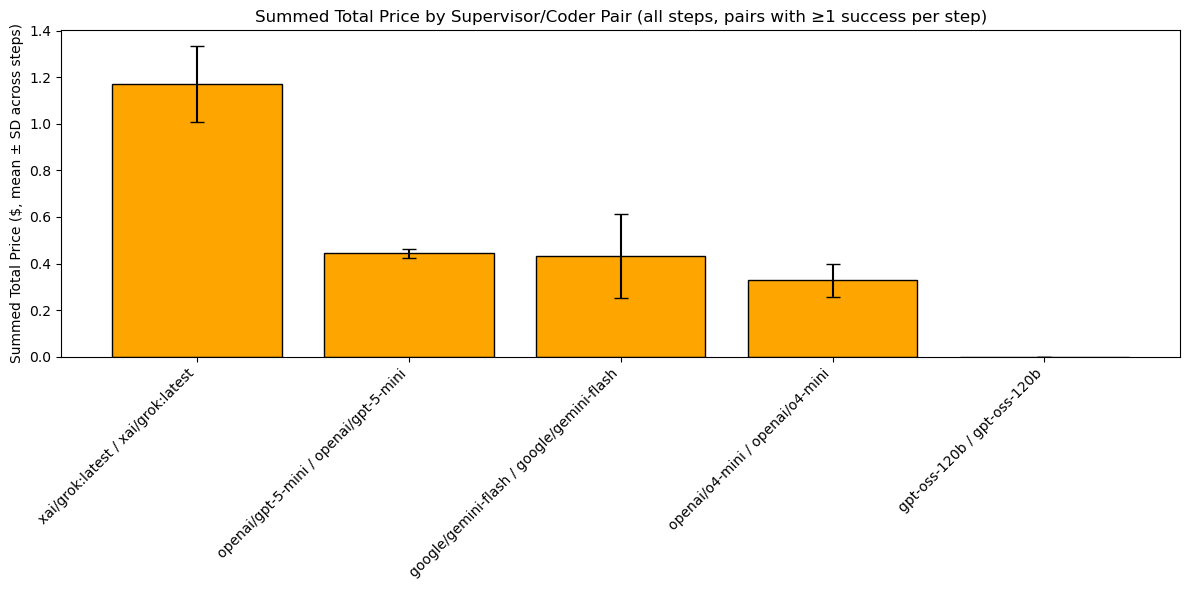

In [31]:
# --- Load and filter data ---
df = pd.read_csv('results_summary.csv', comment='#')
df = df[df['success'] == True]

# Combine supervisor/coder into a single label for plotting
df['pair'] = df['supervisor'] + ' / ' + df['coder']

# --- Filter for pairs with at least one success for every step ---
required_steps = set(df['step'].unique()) # possibly set([1,2,3,4,5]) or whatever steps exist
pairs_with_all_steps = (
    df.groupby('pair')['step']
      .apply(lambda steps: required_steps.issubset(set(steps)))
)
valid_pairs = pairs_with_all_steps[pairs_with_all_steps].index
df = df[df['pair'].isin(valid_pairs)]

# --- Compute total price ---
def compute_total_price(row):
    sup_model = row['supervisor']
    cod_model = row['coder']
    sup_icost = input_cost.get(sup_model, 0)
    sup_ocost = output_cost.get(sup_model, 0)
    cod_icost = input_cost.get(cod_model, 0)
    cod_ocost = output_cost.get(cod_model, 0)
    sup_cost = (row['input_tokens']/1e6)*sup_icost + (row['output_tokens']/1e6)*sup_ocost
    cod_cost = (row['input_tokens']/1e6)*cod_icost + (row['output_tokens']/1e6)*cod_ocost
    return sup_cost + cod_cost

df['total_price'] = df.apply(compute_total_price, axis=1)

# --- Group by pair and step, compute mean and std ---
cost_stats = (
    df.groupby(['pair', 'step'])['total_price']
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .rename(columns={'mean': 'cost_mean', 'std': 'cost_std', 'count': 'n_trials'})
)

# --- Sum means and errors over all steps for each pair ---
def sum_pair_costs(group):
    total_mean = group['cost_mean'].sum()
    total_var = (group['cost_std']**2).sum()
    total_std = np.sqrt(total_var)
    total_trials = group['n_trials'].sum()
    return pd.Series({'sum_cost_mean': total_mean, 'sum_cost_std': total_std, 'total_trials': total_trials})

pair_sums = cost_stats.groupby('pair').apply(sum_pair_costs).reset_index()

# --- Sort by total mean cost descending ---
pair_sums = pair_sums.sort_values('sum_cost_mean', ascending=False).reset_index(drop=True)

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, max(6, 1*len(pair_sums))))
y = np.arange(len(pair_sums))
ax.bar(
    y,
    pair_sums['sum_cost_mean'],
    yerr=pair_sums['sum_cost_std'],
    capsize=5,
    color='orange',
    edgecolor='black'
)

ax.set_xticks(y)
ax.set_xticklabels(pair_sums['pair'], rotation=45, ha='right')
ax.set_ylabel('Summed Total Price ($, mean ± SD across steps)')
ax.set_title('Summed Total Price by Supervisor/Coder Pair (all steps, pairs with ≥1 success per step)')
plt.tight_layout()
plt.show()

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

# Load data
df = pd.read_csv('results_summary.csv', comment='#')

# Filter for only successful trials
df = df[df['success'] == True]

# Combine supervisor/coder into a single label for plotting
df['pair'] = df['supervisor'] + ' / ' + df['coder']

# Select token columns to analyze
token_cols = [
    'input_tokens', 'output_tokens', 'user_prompt_tokens',
    'supervisor_to_coder_tokens', 'coder_output_tokens', 'feedback_to_supervisor_tokens'
]

# Group by pair and step, then compute mean and standard deviation (std)
grouped_mean = df.groupby(['pair', 'step'])[token_cols].mean().reset_index()
grouped_std = df.groupby(['pair', 'step'])[token_cols].std().reset_index()

# Also count number of trials for each group
trial_counts = df.groupby(['pair', 'step']).size().reset_index(name='n_trials')
grouped_mean = pd.merge(grouped_mean, trial_counts, on=['pair', 'step'])
grouped_std = pd.merge(grouped_std, trial_counts, on=['pair', 'step'])

# Prepare all (pair, step) combinations for plotting
plot_data = []
steps = sorted(grouped_mean['step'].unique())
for step in steps:
    sub_mean = grouped_mean[grouped_mean['step'] == step].sort_values('pair')
    sub_std = grouped_std[grouped_std['step'] == step].sort_values('pair')
    for idx, row in sub_mean.iterrows():
        pair = row['pair']
        n_trials = row['n_trials']
        means = [row[col] for col in token_cols]
        stds = [sub_std.loc[idx, col] for col in token_cols]
        plot_data.append({
            'pair': pair,
            'step': step,
            'n_trials': n_trials,
            'means': means,
            'stds': stds
        })

# Define grid size (e.g., 2 columns, 3 rows per page)
ncols = 2
nrows = 3
plots_per_page = ncols * nrows

pdf_filename = 'token_utilization.pdf'
with PdfPages(pdf_filename) as pdf:
    for i in range(0, len(plot_data), plots_per_page):
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*5))
        axes = axes.flatten() if plots_per_page > 1 else [axes]
        for j, pdata in enumerate(plot_data[i:i+plots_per_page]):
            ax = axes[j]
            x = np.arange(len(token_cols))
            bars = ax.bar(x, pdata['means'], yerr=pdata['stds'], capsize=5)
            for rect, mean in zip(bars, pdata['means']):
                if not np.isnan(mean):
                    ax.annotate(f'{mean:.0f}',
                                xy=(rect.get_x() + rect.get_width() / 2, mean),
                                xytext=(0, 3),
                                textcoords="offset points",
                                ha='center', va='bottom', fontsize=9)
            ax.set_xticks(x)
            ax.set_xticklabels(token_cols, rotation=30, ha='right')
            ax.set_ylabel('Average Tokens ± SD')
            ax.set_title(f'{pdata["pair"]} - Step {int(pdata["step"])} (n={int(pdata["n_trials"])})')
        # Hide unused axes
        for k in range(j+1, plots_per_page):
            fig.delaxes(axes[k])
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

print(f"Saved all plots to {pdf_filename}")

/tmp/ipykernel_300166/4254245824.py:55: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  with PdfPages(pdf_filename) as pdf:


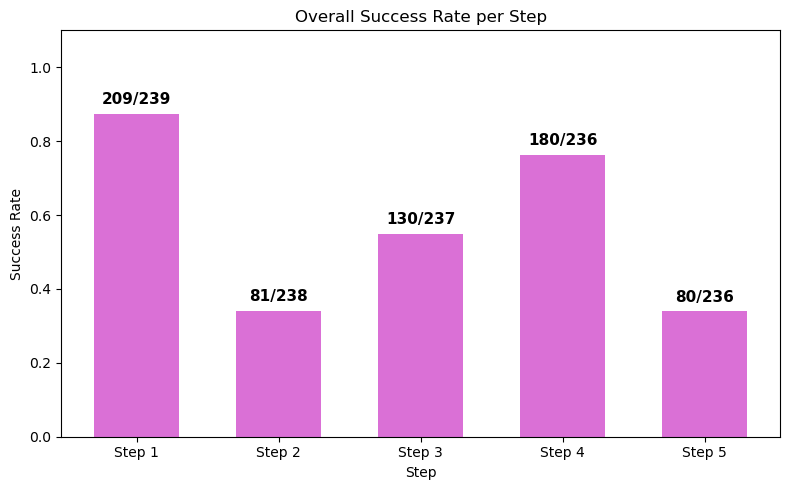

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('results_summary.csv', comment="#")

# Combine supervisor/coder into a single label for plotting
df['pair'] = df['supervisor'] + ' / ' + df['coder']

# Group by pair and step, compute success rate and raw counts
summary = (
    df.groupby(['pair', 'step'])
      .agg(success_rate=('success', 'mean'),
           n_success=('success', 'sum'),
           n_total=('success', 'count'))
      .reset_index()
)

# For clarity, sort by step
summary = summary.sort_values(['pair', 'step'])

# ---- OVERALL PLOT ----
overall = (
    df.groupby('step')
      .agg(success_rate=('success', 'mean'),
           n_success=('success', 'sum'),
           n_total=('success', 'count'))
      .reset_index()
      .sort_values('step')
)

x = np.arange(len(overall['step']))
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(x, overall['success_rate'], color='orchid', width=0.6)

# Annotate bar with raw numbers
for idx, rect in enumerate(bars):
    rate = overall['success_rate'].iloc[idx]
    n_succ = int(overall['n_success'].iloc[idx])
    n_tot = int(overall['n_total'].iloc[idx])
    ax.annotate(f'{n_succ}/{n_tot}',
                xy=(rect.get_x() + rect.get_width() / 2, rate),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, color='black', weight='bold')

ax.set_xticks(x)
ax.set_xticklabels([f"Step {int(s)}" for s in overall['step']])
ax.set_ylim(0, 1.1)
ax.set_ylabel('Success Rate')
ax.set_xlabel('Step')
ax.set_title('Overall Success Rate per Step')
plt.tight_layout()
plt.show()

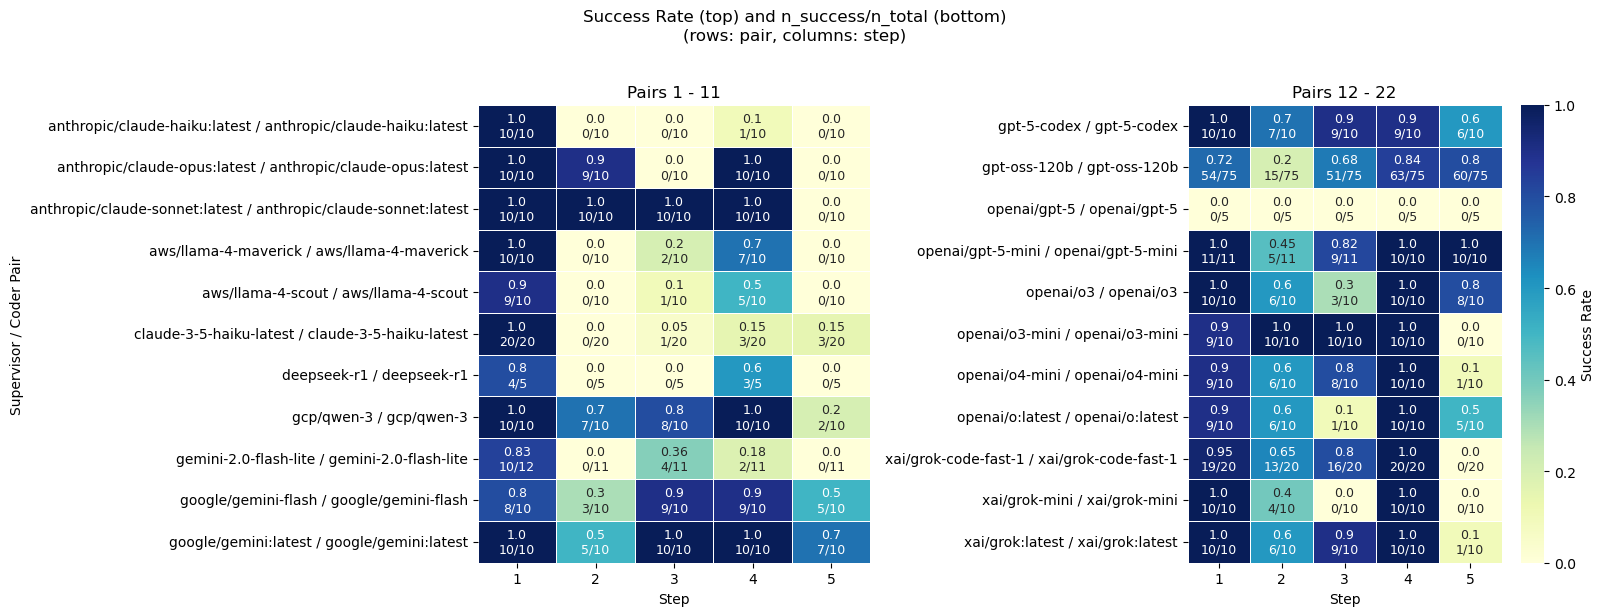

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -----------------
# 1. LOAD DATAFRAME
# -----------------
df = pd.read_csv('results_summary.csv', comment="#")

# Combine supervisor/coder into a single label for plotting
df['pair'] = df['supervisor'] + ' / ' + df['coder']

# -------------------------------
# 2. GROUP AND SUMMARIZE THE DATA
# -------------------------------
summary = (
    df.groupby(['pair', 'step'])
      .agg(success_rate=('success', 'mean'),
           n_success=('success', 'sum'),
           n_total=('success', 'count'))
      .reset_index()
)

# Ensure steps are sorted integers for plotting order
summary['step'] = summary['step'].astype(int)
summary = summary.sort_values(['pair', 'step'])

# --------------------------------------
# 3. PIVOT FOR HEATMAP + ANNOTATION MATRICES
# --------------------------------------
pivot_rate = summary.pivot(index='pair', columns='step', values='success_rate')
pivot_succ = summary.pivot(index='pair', columns='step', values='n_success')
pivot_tot  = summary.pivot(index='pair', columns='step', values='n_total')

annot = pivot_rate.round(2).astype(str) + "\n" + \
        pivot_succ.fillna(0).astype(int).astype(str) + "/" + pivot_tot.fillna(0).astype(int).astype(str)

# --------------------------------------
# 4. SPLIT PAIRS LIST AND PLOT TWO HEATMAPS
# --------------------------------------

pairs = pivot_rate.index.tolist()
N = len(pairs)
half = N // 2 + (N % 2 > 0)  # round up for uneven

pair_slices = [pairs[:half], pairs[half:]]

fig, axes = plt.subplots(1, 2, figsize=(max(8, 0.5 * len(summary['step'].unique())) * 2,
                                        max(6, 0.45 * half)))

for i, ax in enumerate(axes):
    pairs_this = pair_slices[i]
    p_rate = pivot_rate.loc[pairs_this]
    p_annot = annot.loc[pairs_this]
    sns.heatmap(
        p_rate, 
        annot=p_annot, fmt='', linewidths=.5, cmap="YlGnBu", 
        cbar=i == 1,              # show colorbar only on the last plot
        cbar_kws={'label': 'Success Rate'} if i == 1 else None,
        annot_kws={"fontsize":9, "va":"center"},
        ax=ax
    )
    ax.set_xlabel("Step")
    if i == 0:
        ax.set_ylabel("Supervisor / Coder Pair")
    else:
        ax.set_ylabel("")
    ax.set_title(f"Pairs {1 + i*half} - {min((i+1)*half, N)}")
    ax.tick_params(axis='y', labelrotation=0)

plt.suptitle("Success Rate (top) and n_success/n_total (bottom)\n(rows: pair, columns: step)", y=1.02)
plt.tight_layout()
plt.show()

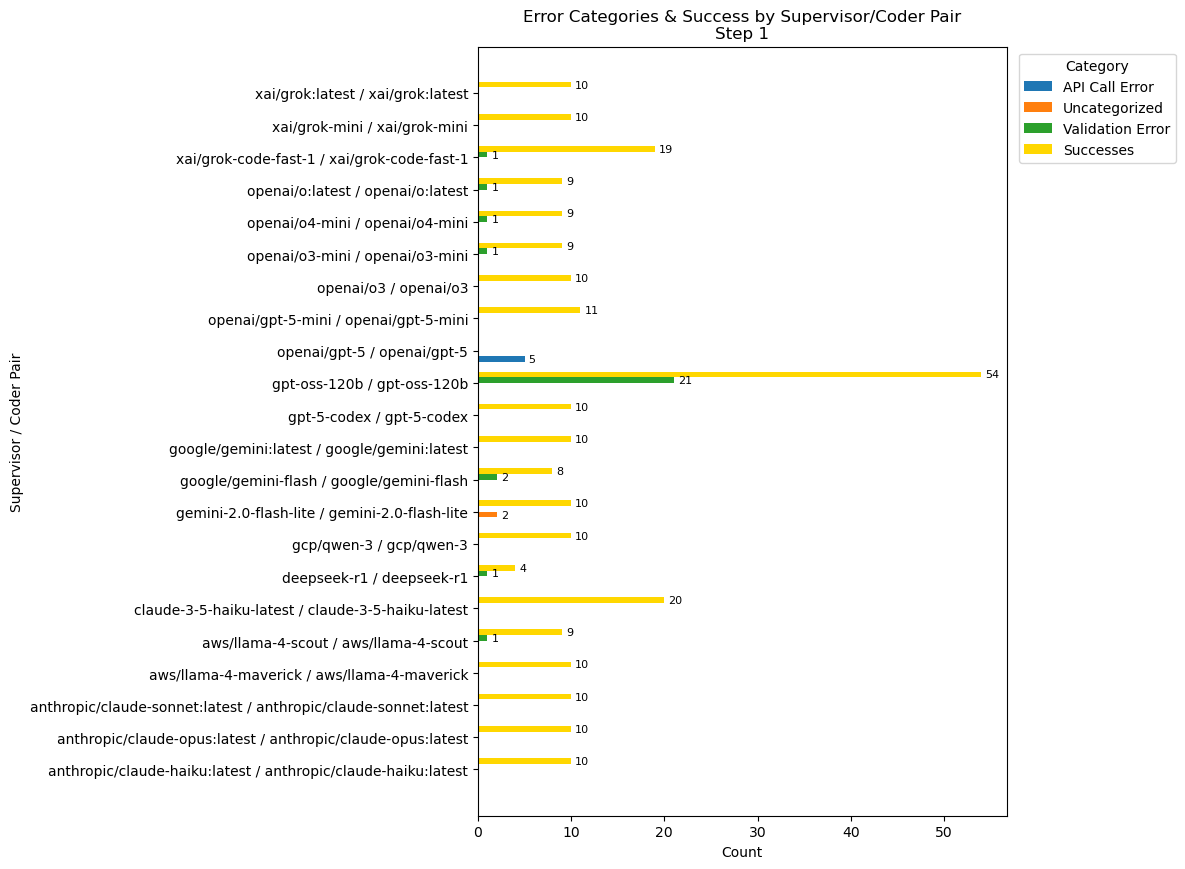

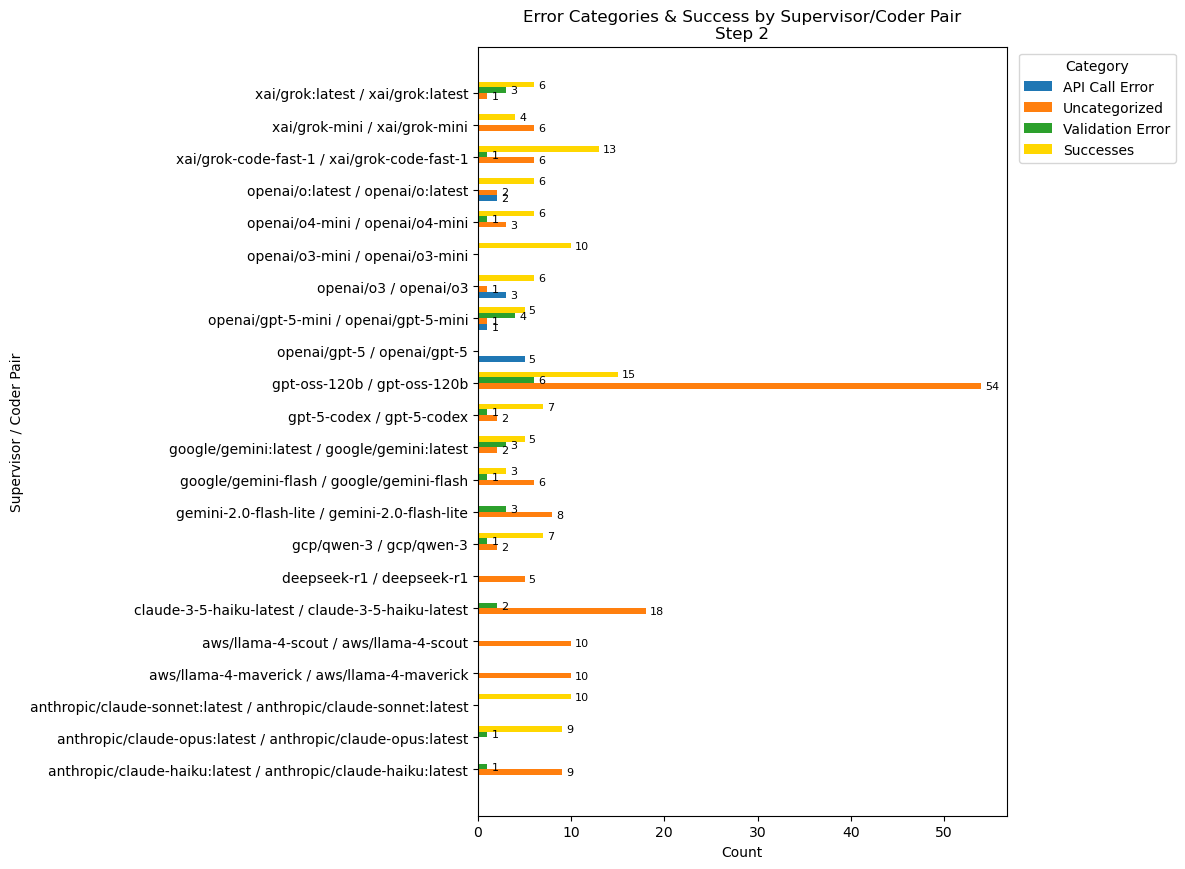

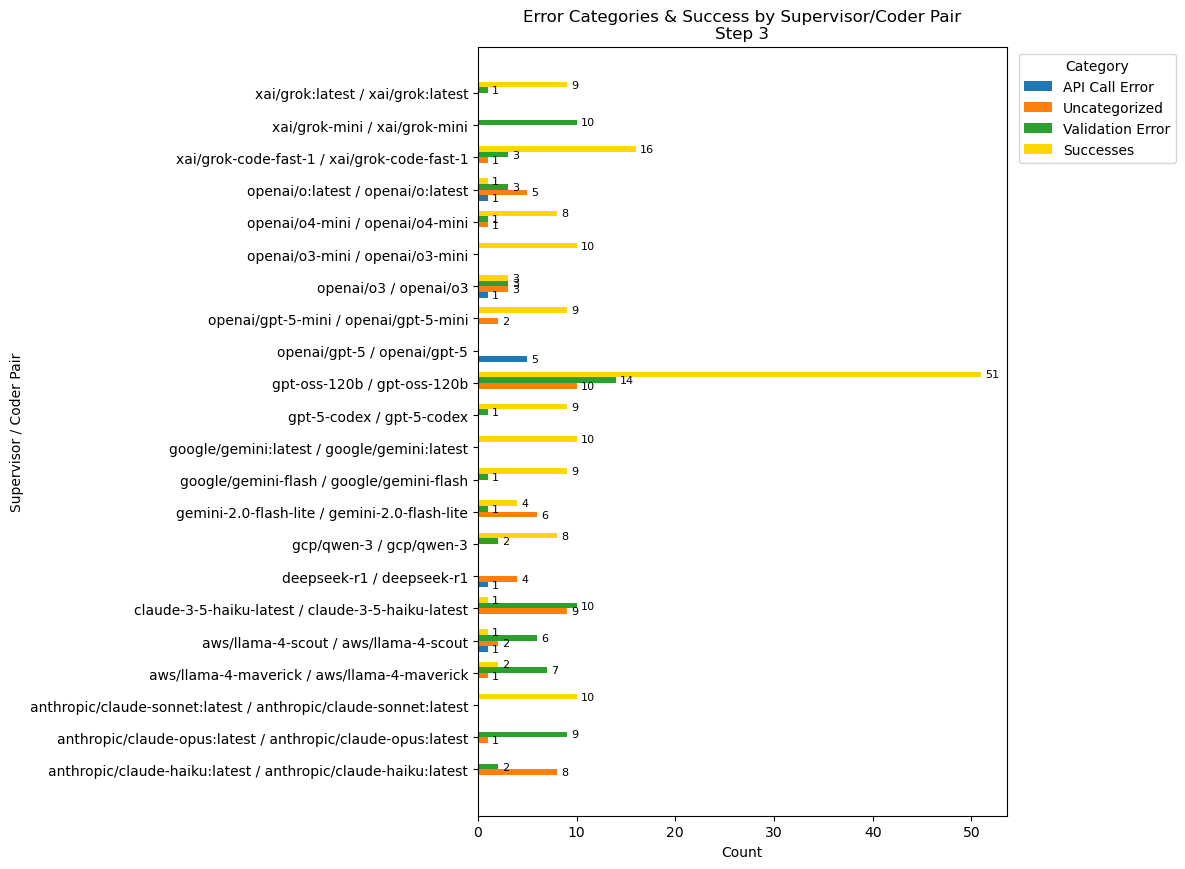

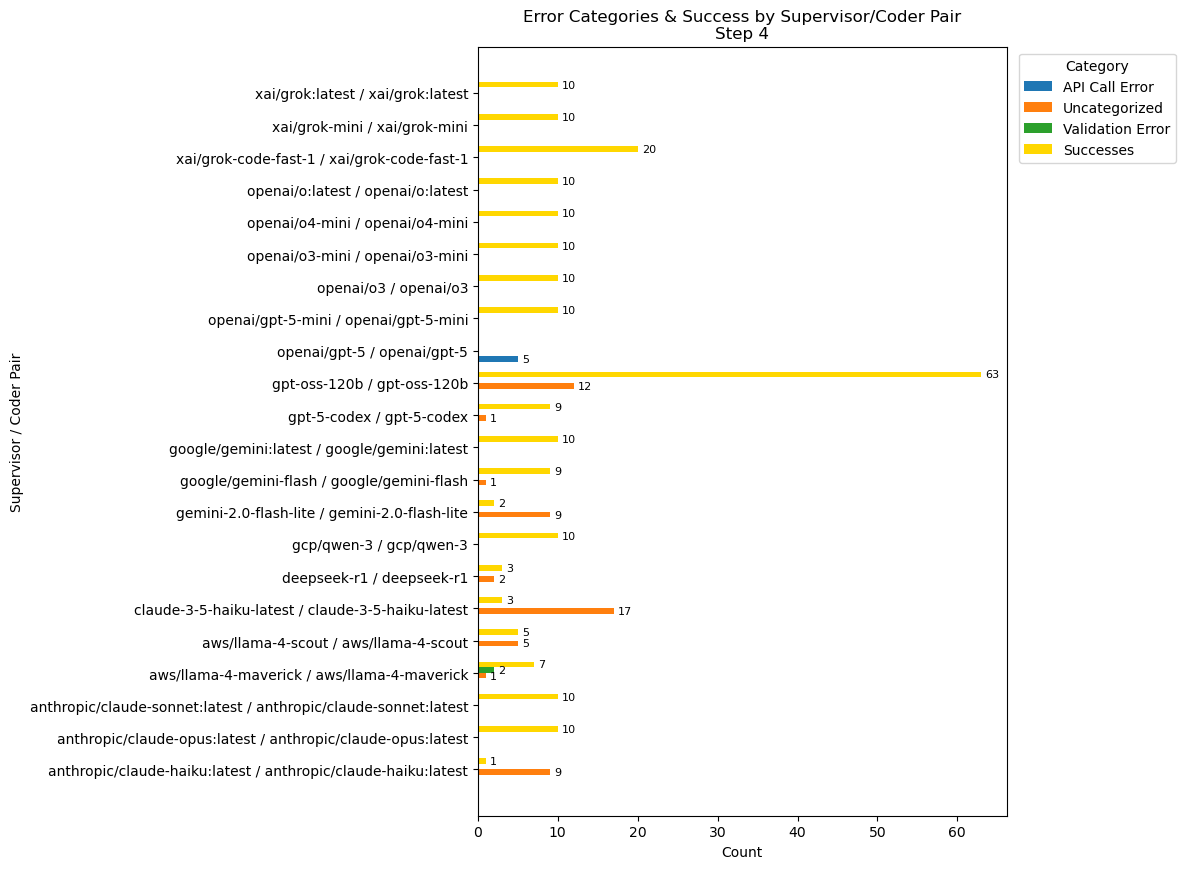

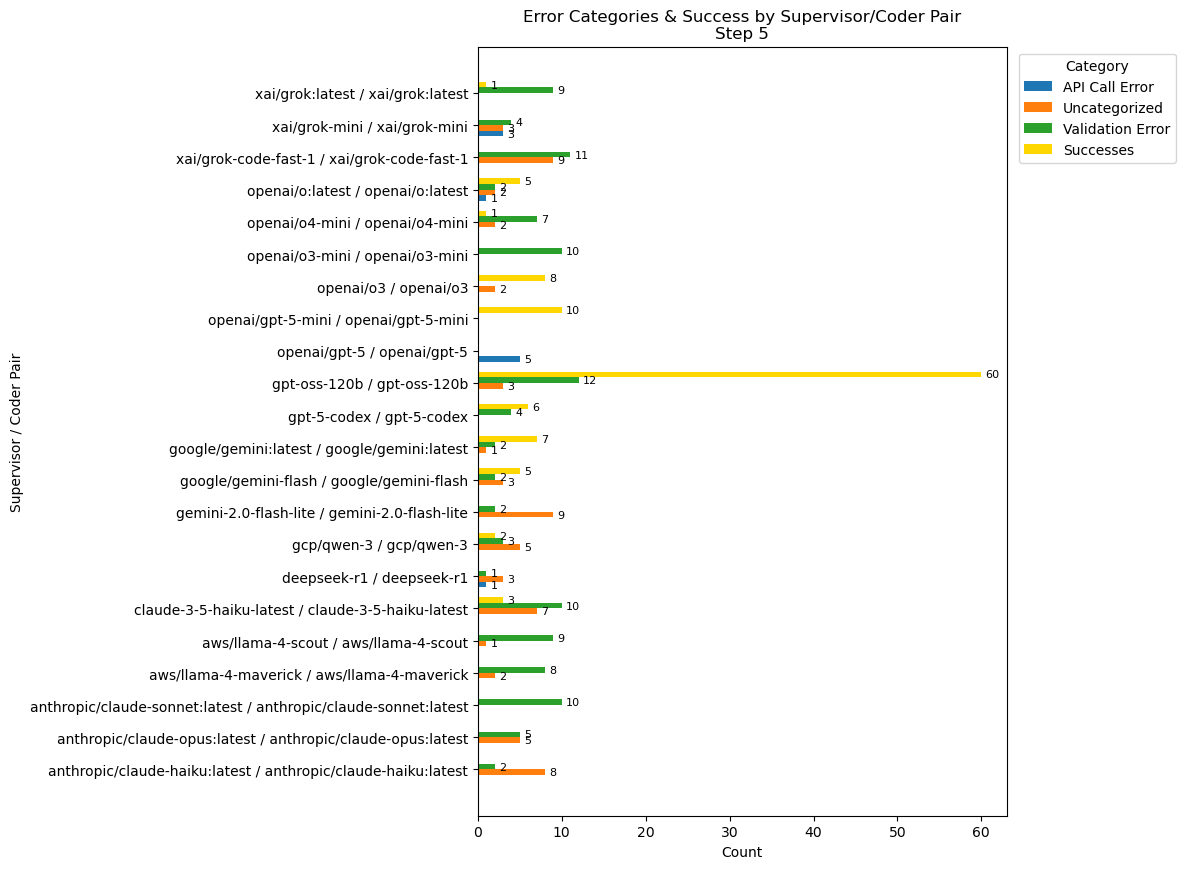

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv('results_summary.csv', comment="#")
df = df[df['step'].notna()]
df = df[df['supervisor'].notna() & df['coder'].notna()]
df['pair'] = df['supervisor'].astype(str) + " / " + df['coder'].astype(str)

steps = sorted(df['step'].dropna().unique())
error_categories = sorted(df.loc[~df['success'], 'error'].dropna().astype(str).unique())
all_categories = error_categories + ['success']  # last is always 'success'

# Robust color assignment (distinct for success)
tab10 = plt.get_cmap('tab10')
n_colors = len(tab10.colors)
category_colors = {cat: tab10(i % n_colors) for i, cat in enumerate(error_categories)}
category_colors['success'] = "gold"

for i, step in enumerate(steps):
    step_df = df[df['step'] == step]
    pairs = sorted(step_df['pair'].dropna().astype(str).unique())
    count_matrix = np.zeros((len(pairs), len(all_categories)), dtype=int)
    for pi, pair in enumerate(pairs):
        # Error counts (for failures only)
        failed_errors = step_df[(step_df['pair'] == pair) & (~step_df['success'])]
        pair_errors = failed_errors['error'].astype(str).value_counts()
        for ec_idx, ec in enumerate(error_categories):
            count_matrix[pi, ec_idx] = pair_errors.get(ec, 0)
        # Success count
        success_count = step_df[(step_df['pair'] == pair) & (step_df['success'])].shape[0]
        count_matrix[pi, -1] = success_count

    y = np.arange(len(pairs))
    bar_height = 0.7 / len(all_categories)

    fig, ax = plt.subplots(figsize=(max(12, 0.28*len(pairs)), max(7, 0.4*len(pairs))))
    for cat_idx, cat in enumerate(all_categories):
        offsets = y - 0.35 + cat_idx*bar_height + bar_height/2
        label = cat if cat != 'success' else 'Successes'
        color = category_colors[cat]
        bars = ax.barh(offsets, count_matrix[:, cat_idx], height=bar_height,
                       label=label, color=color)
        for bi, rect in enumerate(bars):
            count = count_matrix[bi, cat_idx]
            if count > 0:
                ax.annotate(f"{count}",
                            xy=(count, rect.get_y() + rect.get_height()/2),
                            xytext=(3, 0),
                            textcoords="offset points",
                            ha='left', va='center', fontsize=8, color='black')

    ax.set_yticks(y)
    ax.set_yticklabels(pairs)
    ax.set_xlabel('Count')
    ax.set_ylabel('Supervisor / Coder Pair')
    ax.set_title(f'Error Categories & Success by Supervisor/Coder Pair\nStep {int(step)}')
    ax.legend(title="Category", bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

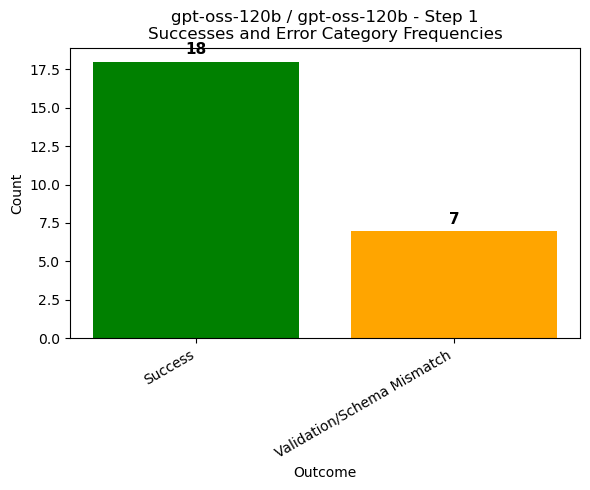

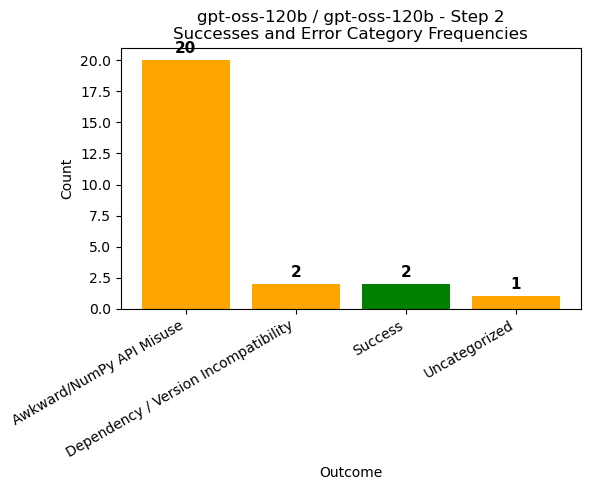

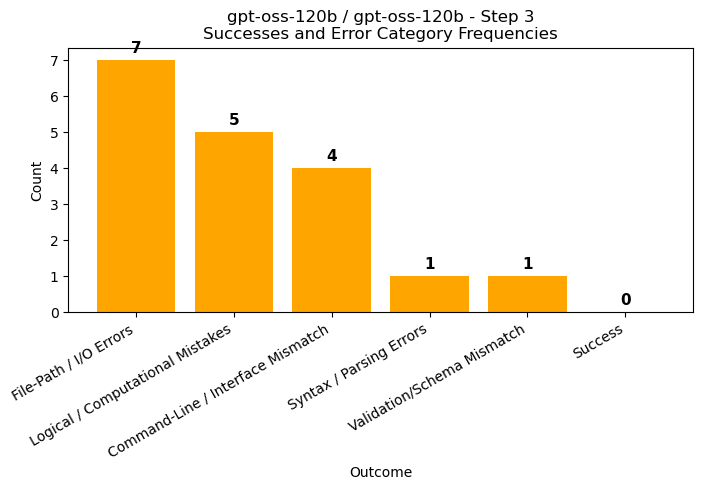

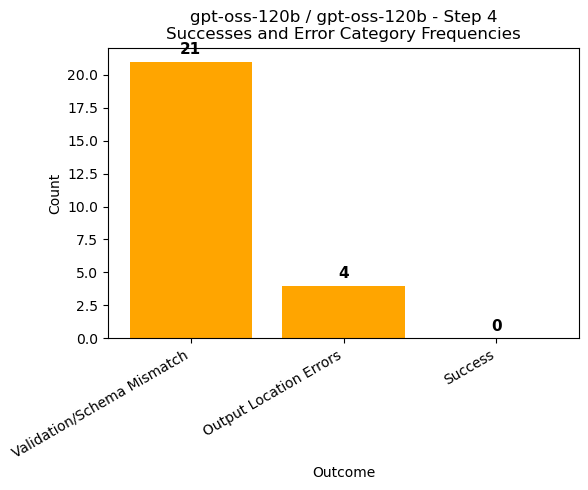

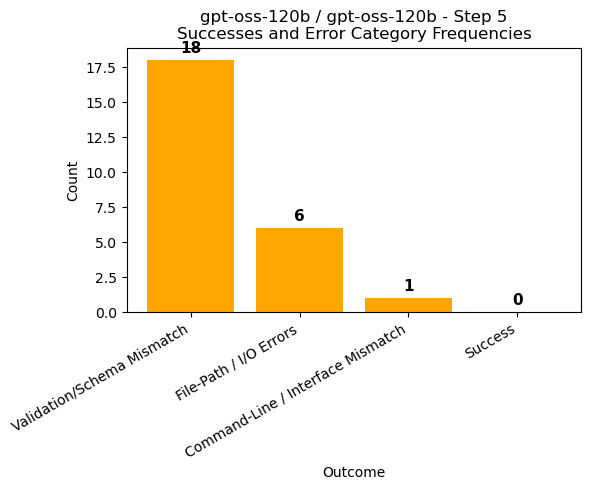

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('results_summary.csv', comment = "#")

# Combine supervisor/coder into a single label for plotting
df['pair'] = df['supervisor'] + ' / ' + df['coder']

pairs = df['pair'].unique()
steps = sorted(df['step'].unique())

for pair in pairs:
    for step in steps:
        sub = df[(df['pair'] == pair) & (df['step'] == step)]
        if sub.empty:
            continue

        # Count successes
        n_success = int(sub['success'].sum())
        # For non-success rows, count error categories
        errors = sub.loc[~sub['success'], 'error'].fillna('Unknown')
        error_counts = errors.value_counts()

        # Combine into a single Series with "Success" as a category
        all_counts = error_counts.copy()
        all_counts['Success'] = n_success
        all_counts = all_counts.sort_values(ascending=False)

        # Plot
        fig, ax = plt.subplots(figsize=(max(6, len(all_counts)*1.2), 5))
        bars = ax.bar(all_counts.index, all_counts.values, color=['green' if cat=='Success' else 'orange' for cat in all_counts.index])

        # Annotate each bar with its count
        for rect, count in zip(bars, all_counts.values):
            ax.annotate(f'{count}',
                        xy=(rect.get_x() + rect.get_width() / 2, count),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=11, color='black', weight='bold')

        ax.set_ylabel('Count')
        ax.set_xlabel('Outcome')
        ax.set_title(f'{pair} - Step {int(step)}\nSuccesses and Error Category Frequencies')
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()
        plt.show()

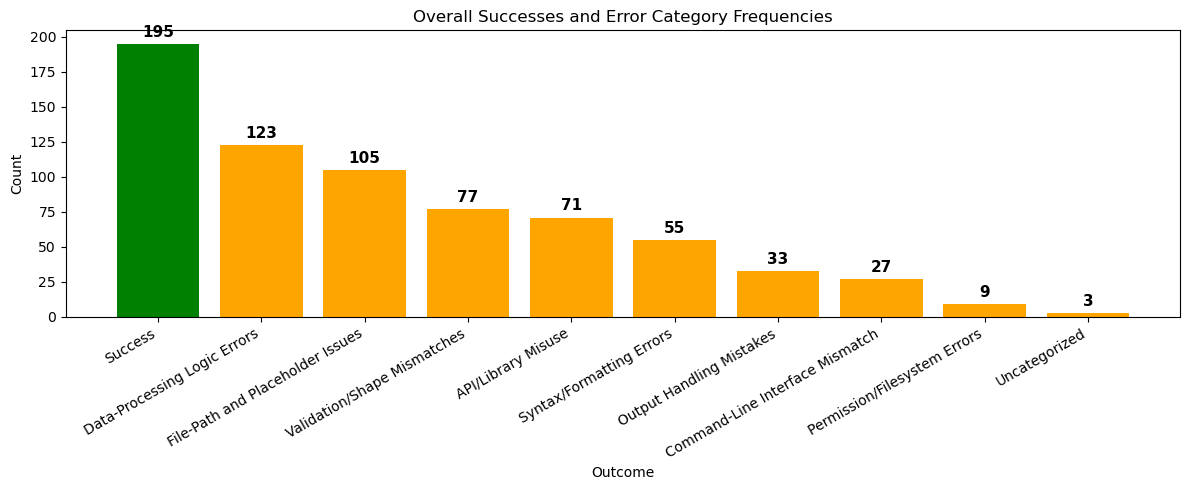

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from collections import Counter

# Load data and parse lists
df = pd.read_csv('results_summary.csv', comment='#')
df['error_categories'] = df['error_categories'].fillna('[]').apply(ast.literal_eval)

# Flatten all error categories into a single list (excluding successes)
all_errors = [cat for cats in df.loc[~df['success'], 'error_categories'] for cat in cats]
error_counts = Counter(all_errors)

# Add success count
n_success = df['success'].sum()
error_counts['Success'] = n_success

# Plot
labels, counts = zip(*sorted(error_counts.items(), key=lambda x: -x[1]))
fig, ax = plt.subplots(figsize=(max(6, len(labels)*1.2), 5))
bars = ax.bar(labels, counts, color=['green' if l=='Success' else 'orange' for l in labels])

for rect, count in zip(bars, counts):
    ax.annotate(f'{count}', xy=(rect.get_x() + rect.get_width() / 2, count),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=11, color='black', weight='bold')

ax.set_ylabel('Count')
ax.set_xlabel('Outcome')
ax.set_title('Overall Successes and Error Category Frequencies')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig('overall_error_categories.pdf')
plt.show()

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from collections import Counter
from matplotlib.backends.backend_pdf import PdfPages

# Load data and parse lists
df = pd.read_csv('results_summary.csv', comment='#')
df['error_categories'] = df['error_categories'].fillna('[]').apply(ast.literal_eval)

# Prepare PdfPages
with PdfPages('all_error_categories_plots.pdf') as pdf:

    # --- Overall Plot ---
    all_errors = [cat for cats in df.loc[~df['success'], 'error_categories'] for cat in cats]
    error_counts = Counter(all_errors)
    n_success = df['success'].sum()
    error_counts['Success'] = n_success

    labels, counts = zip(*sorted(error_counts.items(), key=lambda x: -x[1]))
    fig, ax = plt.subplots(figsize=(max(6, len(labels)*1.2), 5))
    bars = ax.bar(labels, counts, color=['green' if l=='Success' else 'orange' for l in labels])
    for rect, count in zip(bars, counts):
        ax.annotate(f'{count}', xy=(rect.get_x() + rect.get_width() / 2, count),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, color='black', weight='bold')
    ax.set_ylabel('Count')
    ax.set_xlabel('Outcome')
    ax.set_title('Overall Successes and Error Category Frequencies')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

    # --- Per Supervisor/Coder/Step Plots ---
    df['pair'] = df['supervisor'] + ' / ' + df['coder']
    steps = sorted(df['step'].unique())
    for pair in df['pair'].unique():
        for step in steps:
            sub = df[(df['pair'] == pair) & (df['step'] == step)]
            if sub.empty:
                continue

            error_list = [cat for cats in sub.loc[~sub['success'], 'error_categories'] for cat in cats]
            error_counts = Counter(error_list)
            n_success = sub['success'].sum()
            error_counts['Success'] = n_success

            labels, counts = zip(*sorted(error_counts.items(), key=lambda x: -x[1]))
            fig, ax = plt.subplots(figsize=(max(6, len(labels)*1.2), 5))
            bars = ax.bar(labels, counts, color=['green' if l=='Success' else 'orange' for l in labels])
            for rect, count in zip(bars, counts):
                ax.annotate(f'{count}',
                            xy=(rect.get_x() + rect.get_width() / 2, count),
                            xytext=(0, 3), textcoords="offset points",
                            ha='center', va='bottom', fontsize=11, color='black', weight='bold')
            ax.set_ylabel('Count')
            ax.set_xlabel('Outcome')
            ax.set_title(f'{pair} - Step {int(step)}\nSuccesses and Error Category Frequencies')
            plt.xticks(rotation=30, ha='right')
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)

print("All plots saved to all_error_categories_plots.pdf")

All plots saved to all_error_categories_plots.pdf
